In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


In [2]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [3]:
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [4]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 41.912239 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [7]:
result[result.isnull().any(axis=1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID']==1109]

ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


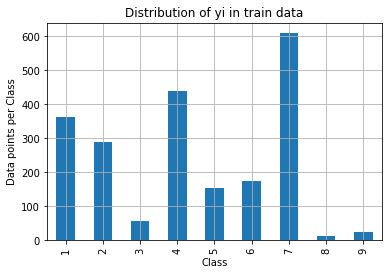

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


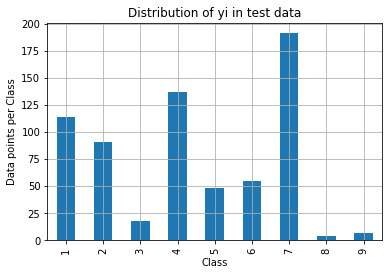

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


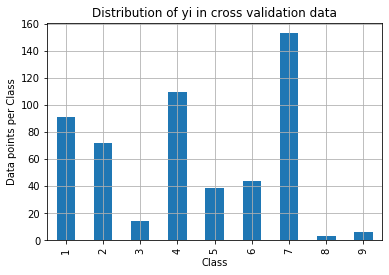

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [12]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4897995648457383
Log loss on Test Data using Random Model 2.4861632637372475
-------------------- Confusion matrix --------------------


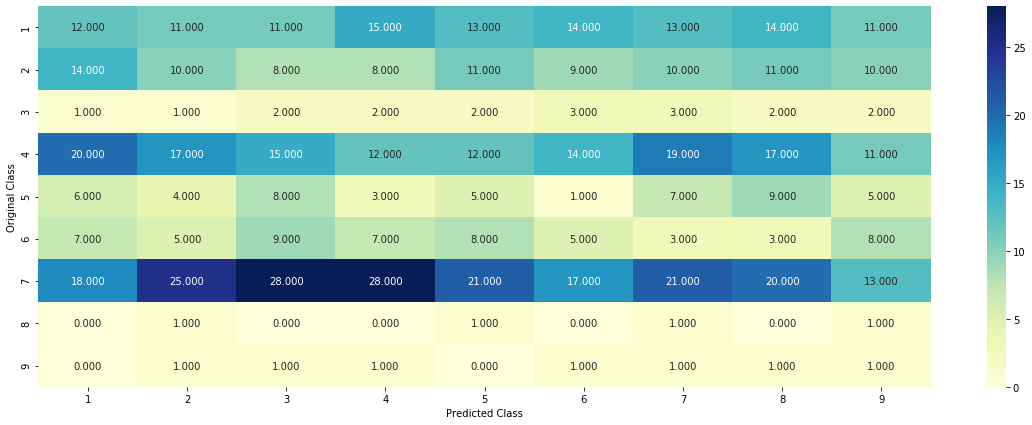

-------------------- Precision matrix (Columm Sum=1) --------------------


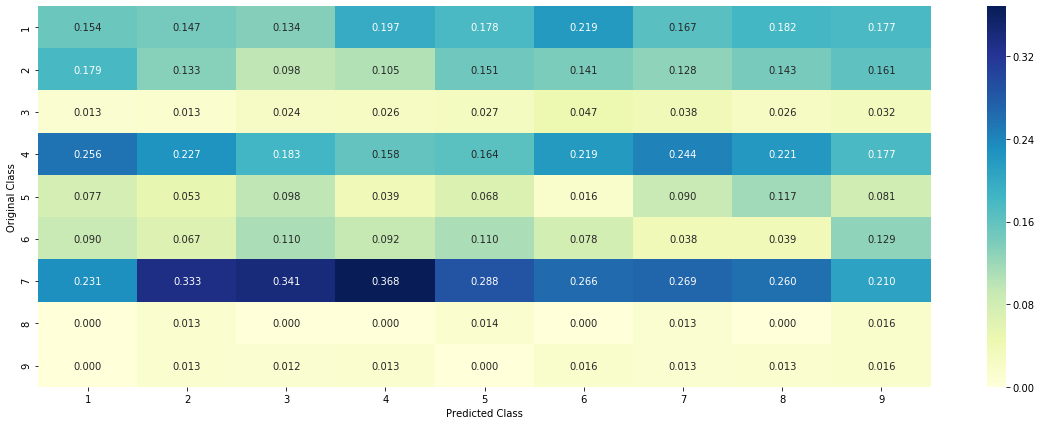

-------------------- Recall matrix (Row sum=1) --------------------


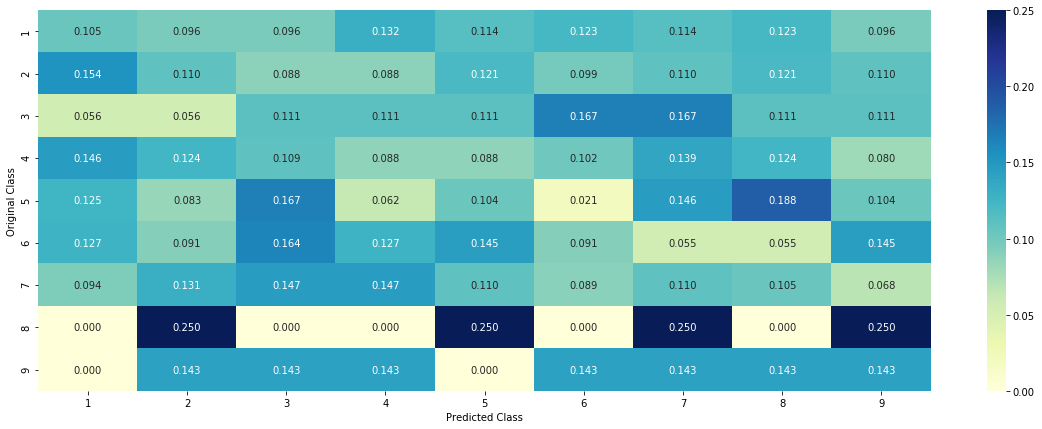

In [14]:

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [15]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 237
BRCA1     158
TP53      120
BRCA2      87
EGFR       86
PTEN       85
BRAF       60
KIT        59
ALK        49
PIK3CA     39
PDGFRA     37
Name: Gene, dtype: int64


In [16]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 237 different categories of genes in the train data, and they are distibuted as follows


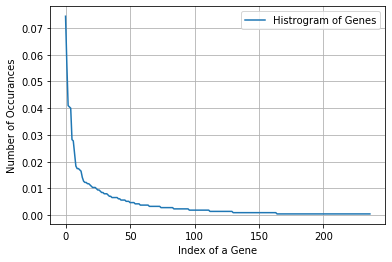

In [17]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


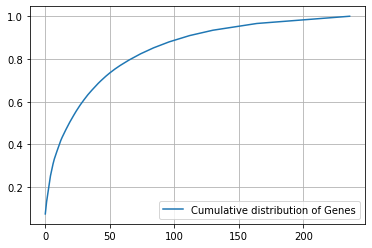

In [18]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [19]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [20]:
train_df['Gene'].head()

3184    TCF7L2
2849     BRCA2
5          CBL
589      SMAD4
1038      TSC2
Name: Gene, dtype: object

In [21]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',

In [22]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 237)


For values of alpha =  1e-05 The log loss is: 1.2462086627260929
For values of alpha =  0.0001 The log loss is: 1.2212607364028871
For values of alpha =  0.001 The log loss is: 1.2621664024680002
For values of alpha =  0.01 The log loss is: 1.3840214150966856
For values of alpha =  0.1 The log loss is: 1.461684429432527
For values of alpha =  1 The log loss is: 1.4868669860359405


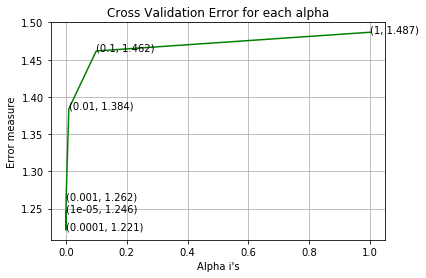

For values of best alpha =  0.0001 The train log loss is: 1.0039089723772519
For values of best alpha =  0.0001 The cross validation log loss is: 1.2212607364028871
For values of best alpha =  0.0001 The test log loss is: 1.1442661859318324


In [23]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [24]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  237  genes in train dataset?
Ans
1. In test data 650 out of 665 : 97.74436090225564
2. In cross validation data 513 out of  532 : 96.42857142857143


In [25]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
print(unique_variations.head(10))

Number of Unique Variations : 1915
Truncating_Mutations    64
Deletion                56
Amplification           48
Fusions                 20
Overexpression           5
E17K                     3
G12V                     3
K117N                    2
Q61K                     2
TMPRSS2-ETV1_Fusion      2
Name: Variation, dtype: int64


In [26]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1915 different categories of variations in the train data, and they are distibuted as follows


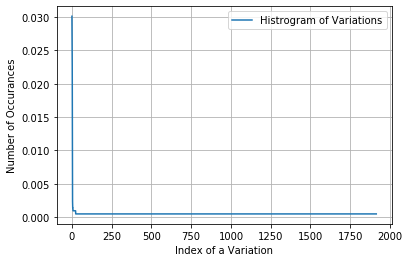

In [27]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.03013183 0.05649718 0.07909605 ... 0.99905838 0.99952919 1.        ]


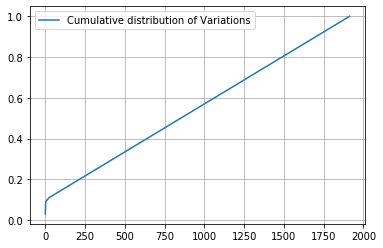

In [28]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [29]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [30]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1940)


For values of alpha =  1e-05 The log loss is: 1.7273072045921667
For values of alpha =  0.0001 The log loss is: 1.7166012499619947
For values of alpha =  0.001 The log loss is: 1.7180127573134774
For values of alpha =  0.01 The log loss is: 1.7264014568967374
For values of alpha =  0.1 The log loss is: 1.7386365926242828
For values of alpha =  1 The log loss is: 1.740950747087816


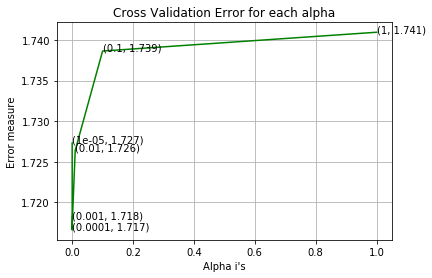

For values of best alpha =  0.0001 The train log loss is: 0.7734950291393291
For values of best alpha =  0.0001 The cross validation log loss is: 1.7166012499619947
For values of best alpha =  0.0001 The test log loss is: 1.722732986245374


In [31]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [32]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1915  genes in test and cross validation data sets?
Ans
1. In test data 56 out of 665 : 8.421052631578947
2. In cross validation data 53 out of  532 : 9.962406015037594


## TASK 1 : Apply All the models with tf-idf features (Replace CountVectorizer with tfidfVectorizer and run the same cells)

In [35]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [38]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidfCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_tfidfCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_tfidfCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52853


In [39]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))

total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [40]:
train_text_feature_tfidfCoding = normalize(train_text_feature_tfidfCoding, axis=0)
test_text_feature_tfidfCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidfCoding = normalize(test_text_feature_tfidfCoding, axis=0)
cv_text_feature_tfidfCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidfCoding = normalize(cv_text_feature_tfidfCoding, axis=0)

In [41]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

For values of alpha =  1e-05 The log loss is: 1.2700056888390439
For values of alpha =  0.0001 The log loss is: 1.1144440341231197
For values of alpha =  0.001 The log loss is: 1.1140729615863072
For values of alpha =  0.01 The log loss is: 1.164067645320866
For values of alpha =  0.1 The log loss is: 1.1608275938064339
For values of alpha =  1 The log loss is: 1.4403001755638822


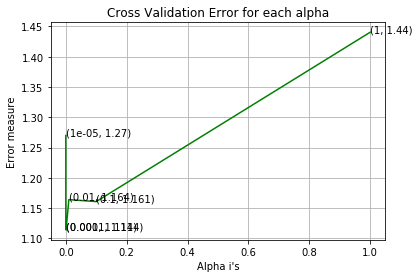

For values of best alpha =  0.001 The train log loss is: 0.6247117004635944
For values of best alpha =  0.001 The cross validation log loss is: 1.1140729615863072
For values of best alpha =  0.001 The test log loss is: 1.046024439235644


In [43]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_text_feature_tfidfCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_tfidfCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_tfidfCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_text_feature_tfidfCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_tfidfCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_tfidfCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_tfidfCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_tfidfCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [44]:
# merging gene, variance and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x = hstack((train_gene_var_onehotCoding, train_text_feature_tfidfCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x = hstack((test_gene_var_onehotCoding, test_text_feature_tfidfCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidfCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [45]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x.shape)
print("(number of data points * number of features) in test data = ", test_x.shape)
print("(number of data points * number of features) in cross validation data =", cv_x.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55043)
(number of data points * number of features) in test data =  (665, 55043)
(number of data points * number of features) in cross validation data = (532, 55043)


In [13]:
#Data preparation for ML models.
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<h3>Naive Bayes</h3>

<h4>Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.2750500109378113
for alpha = 0.0001
Log Loss : 1.2741059560059647
for alpha = 0.001
Log Loss : 1.2641383145532519
for alpha = 0.1
Log Loss : 1.3028330672251103
for alpha = 1
Log Loss : 1.2786986157746878
for alpha = 10
Log Loss : 1.2756359125566108
for alpha = 100
Log Loss : 1.190082335711945
for alpha = 1000
Log Loss : 1.1838506188977598


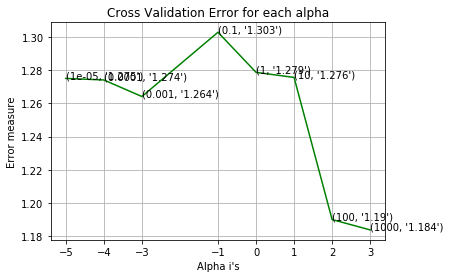

For values of best alpha =  1000 The train log loss is: 0.9256613154468321
For values of best alpha =  1000 The cross validation log loss is: 1.1838506188977598
For values of best alpha =  1000 The test log loss is: 1.18622065059929


In [46]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)


predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>Testing the model with best hyper paramters</h4>

Log Loss : 1.1838506188977598
Number of missclassified point : 0.40037593984962405
-------------------- Confusion matrix --------------------


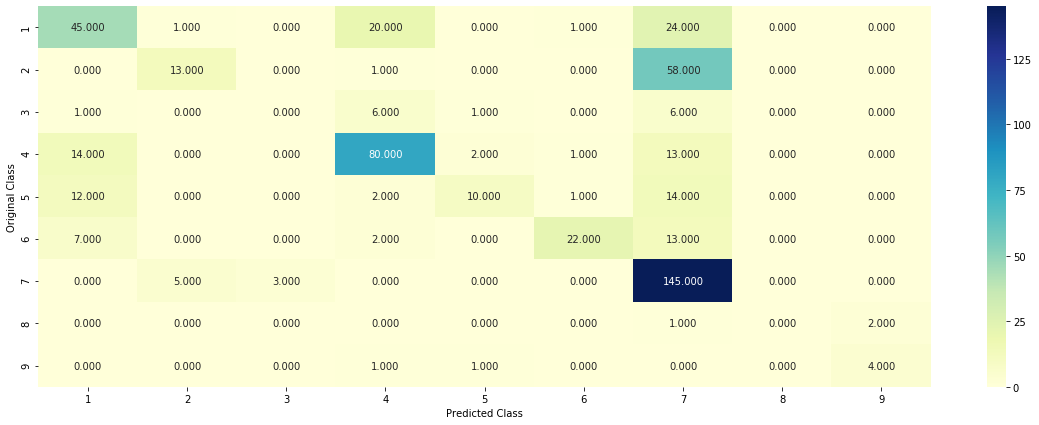

-------------------- Precision matrix (Columm Sum=1) --------------------


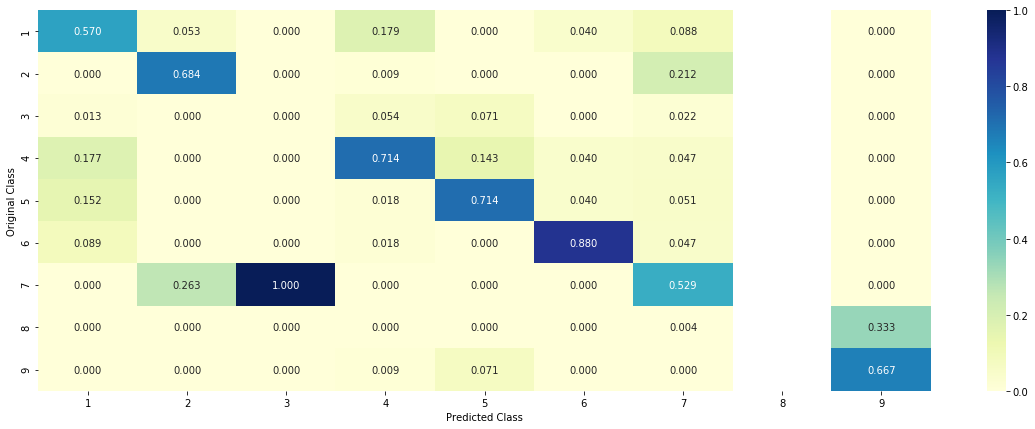

-------------------- Recall matrix (Row sum=1) --------------------


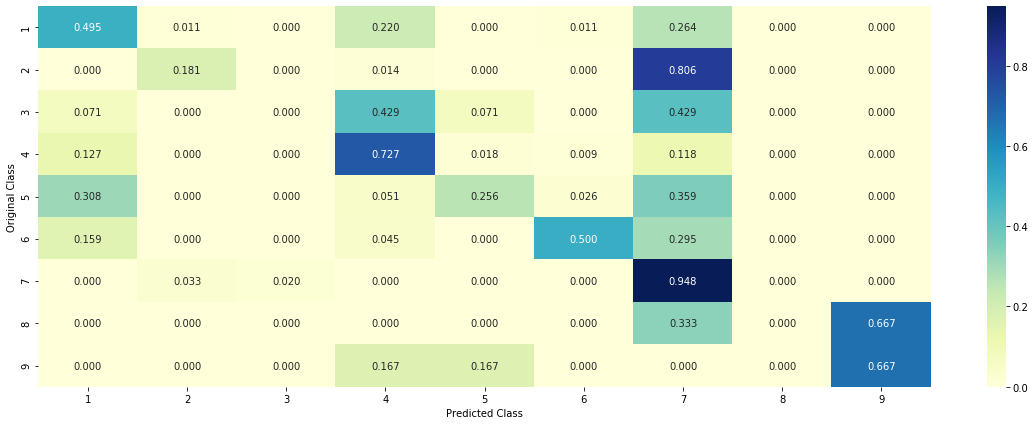

In [47]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x.toarray()))

<h2>K Nearest Neighbour Classification</h2>

<h3>Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.2578610913280357
for alpha = 11
Log Loss : 1.3299743092527831
for alpha = 15
Log Loss : 1.3683692270336285
for alpha = 21
Log Loss : 1.4058897914710091
for alpha = 31
Log Loss : 1.4121785517824064
for alpha = 41
Log Loss : 1.40786908553658
for alpha = 51
Log Loss : 1.4044506935644736
for alpha = 99
Log Loss : 1.3555804474885327


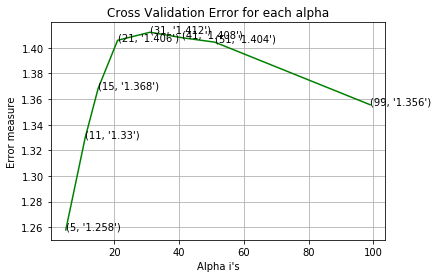

For values of best alpha =  5 The train log loss is: 0.9981221899534375
For values of best alpha =  5 The cross validation log loss is: 1.2578610913280357
For values of best alpha =  5 The test log loss is: 1.2840730974564705


In [52]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>Testing the model with best hyper paramters</h3>

Log loss : 1.2578610913280357
Number of mis-classified points : 0.42293233082706766
-------------------- Confusion matrix --------------------


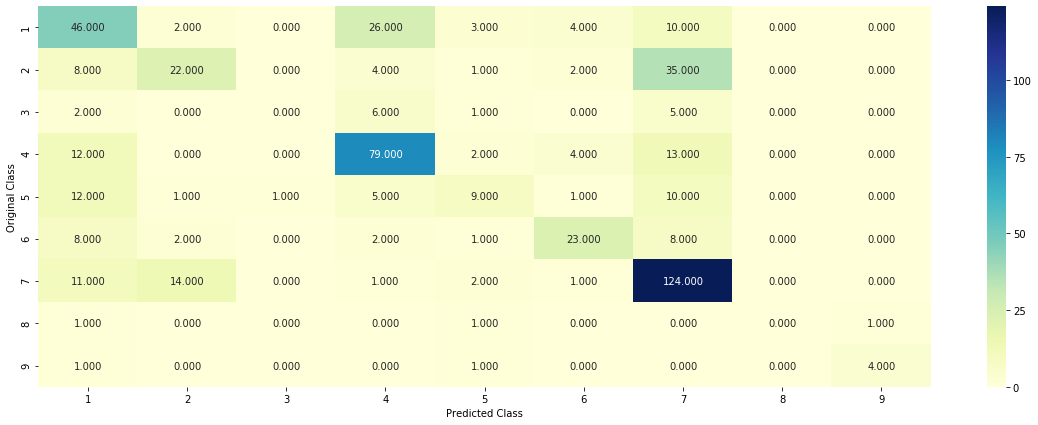

-------------------- Precision matrix (Columm Sum=1) --------------------


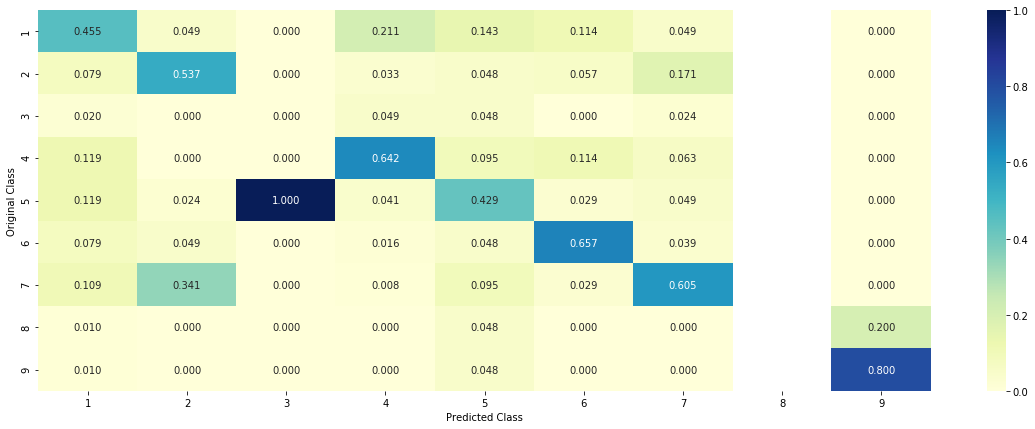

-------------------- Recall matrix (Row sum=1) --------------------


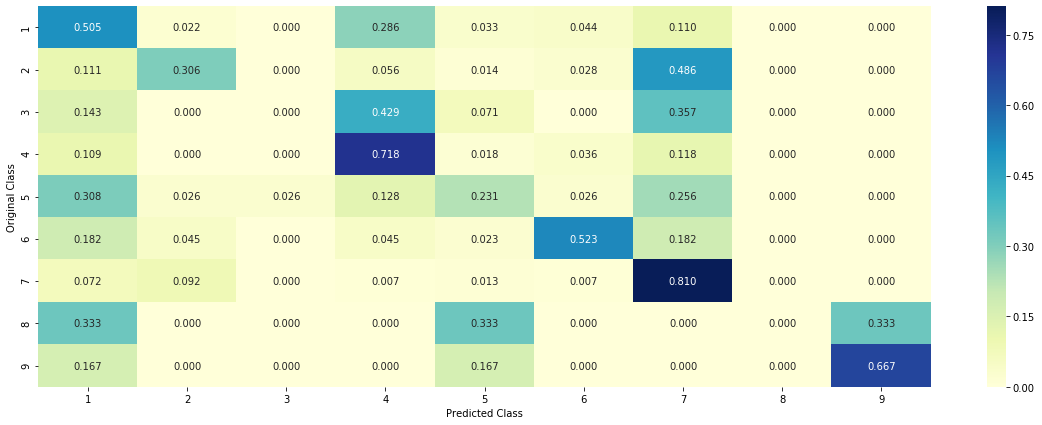

In [53]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

<h3>Sample Query point -1</h3>

In [55]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [1 7 7 2 7]
Fequency of nearest points : Counter({7: 3, 1: 1, 2: 1})


<h3>Sample Query Point-2 </h3>

In [56]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 1
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [4 1 7 6 6]
Fequency of nearest points : Counter({6: 2, 4: 1, 1: 1, 7: 1})


<h2>Logistic Regression</h2>

<h3>With Class balancing</h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.3160633399003063
for alpha = 1e-05
Log Loss : 1.2697557048170263
for alpha = 0.0001
Log Loss : 1.0846425233567432
for alpha = 0.001
Log Loss : 1.0601447908508819
for alpha = 0.01
Log Loss : 1.1059990179296209
for alpha = 0.1
Log Loss : 1.159395392819704
for alpha = 1
Log Loss : 1.3757572413001202
for alpha = 10
Log Loss : 1.4209511980100822
for alpha = 100
Log Loss : 1.4260799271834599


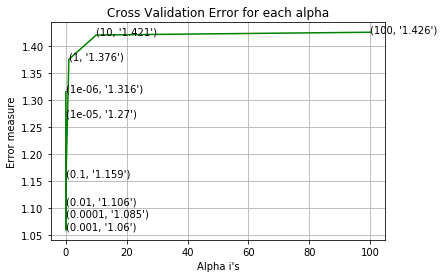

For values of best alpha =  0.001 The train log loss is: 0.5388473327608705
For values of best alpha =  0.001 The cross validation log loss is: 1.0601447908508819
For values of best alpha =  0.001 The test log loss is: 0.9743255757067935


In [57]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing the model with best hyper paramters</h4>

Log loss : 1.0601447908508819
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


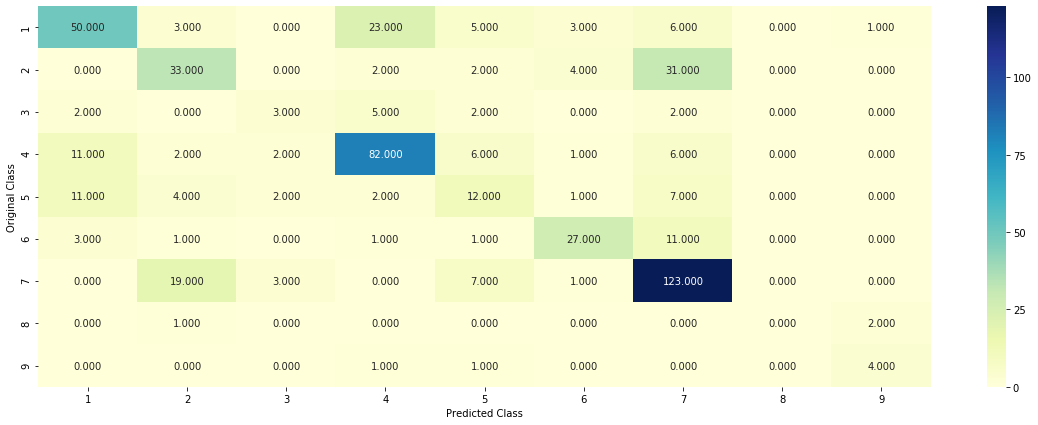

-------------------- Precision matrix (Columm Sum=1) --------------------


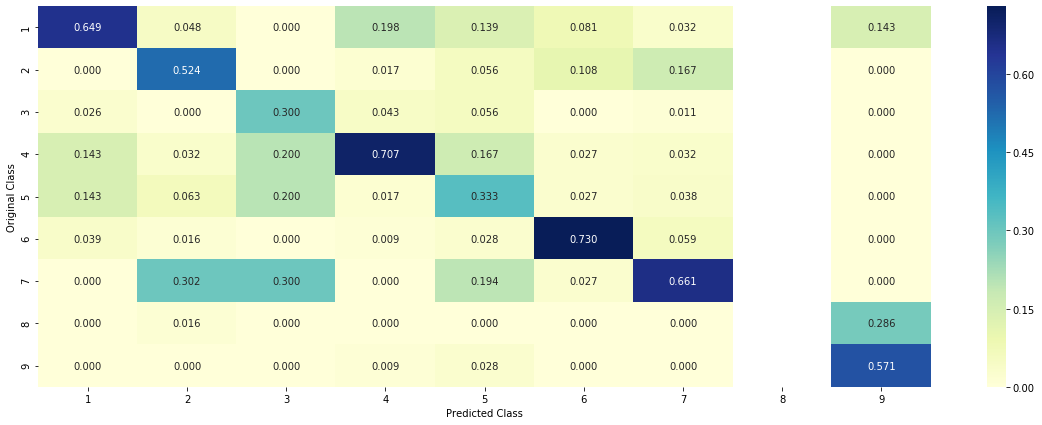

-------------------- Recall matrix (Row sum=1) --------------------


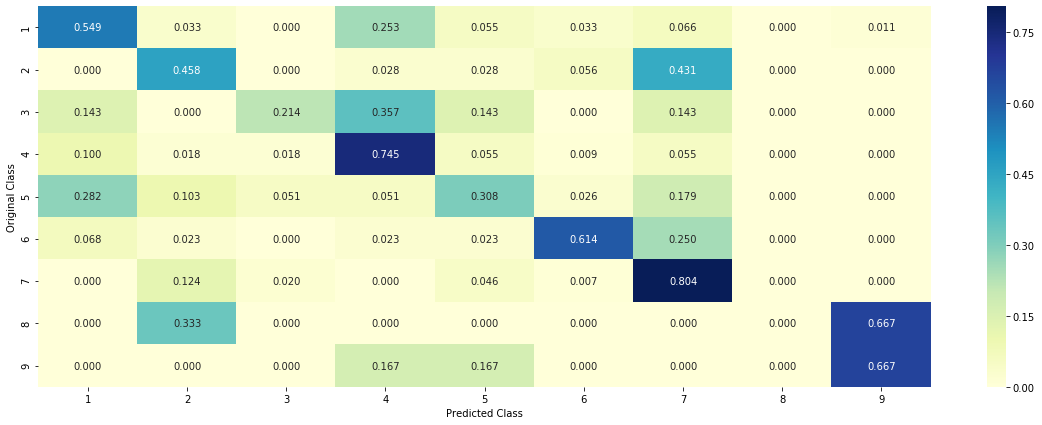

In [58]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

In [59]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h3>Without Class balancing</h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.322677501932817
for alpha = 1e-05
Log Loss : 1.2622183202337292
for alpha = 0.0001
Log Loss : 1.1106112129568722
for alpha = 0.001
Log Loss : 1.085156003394459
for alpha = 0.01
Log Loss : 1.1364909703537918
for alpha = 0.1
Log Loss : 1.1241809661225914
for alpha = 1
Log Loss : 1.3836974100266954


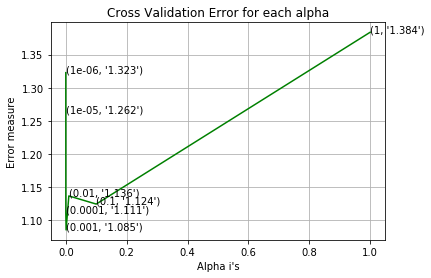

For values of best alpha =  0.001 The train log loss is: 0.5327778436147093
For values of best alpha =  0.001 The cross validation log loss is: 1.085156003394459
For values of best alpha =  0.001 The test log loss is: 0.9874088242840224


In [62]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing model with best hyper parameters</h4>

Log loss : 1.085156003394459
Number of mis-classified points : 0.3609022556390977
-------------------- Confusion matrix --------------------


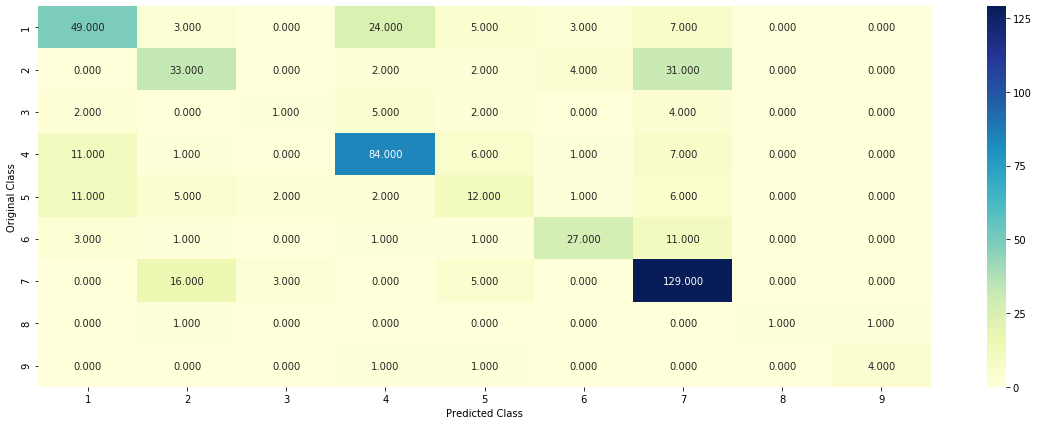

-------------------- Precision matrix (Columm Sum=1) --------------------


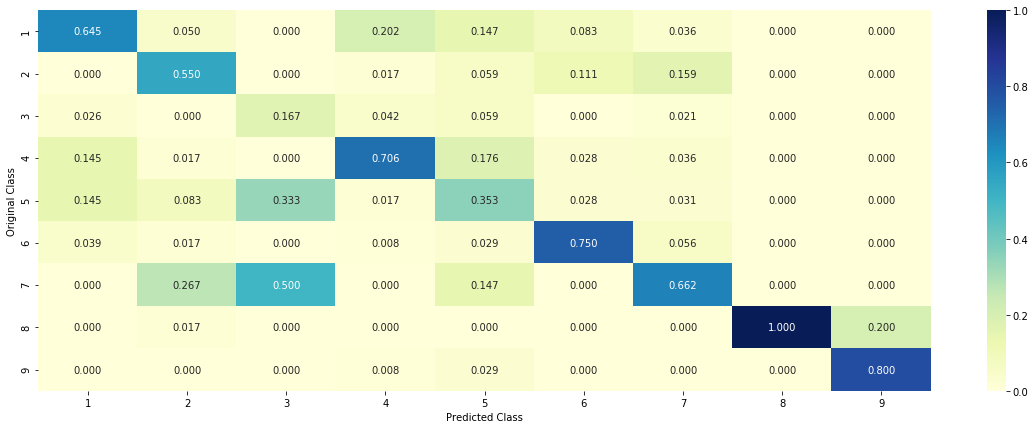

-------------------- Recall matrix (Row sum=1) --------------------


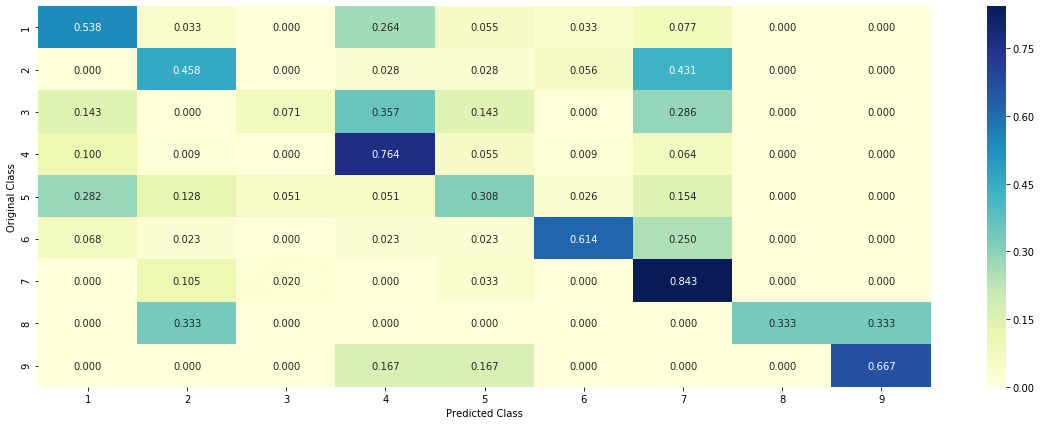

In [63]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

<h2>Linear Support Vector Machines</h2>

<h3>Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.2849889085769106
for C = 0.0001
Log Loss : 1.2153634055446279
for C = 0.001
Log Loss : 1.0943493220861455
for C = 0.01
Log Loss : 1.1402124680715477
for C = 0.1
Log Loss : 1.1868001974505848
for C = 1
Log Loss : 1.4286353261838696
for C = 10
Log Loss : 1.427014806587171
for C = 100
Log Loss : 1.4270148412129304


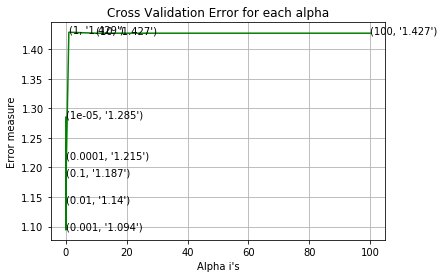

For values of best alpha =  0.001 The train log loss is: 0.5917927966452832
For values of best alpha =  0.001 The cross validation log loss is: 1.0943493220861455
For values of best alpha =  0.001 The test log loss is: 1.0432428539889533


In [66]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42, n_jobs=-1)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>Testing model with best hyper parameters</h3>

Log loss : 1.0943493220861455
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


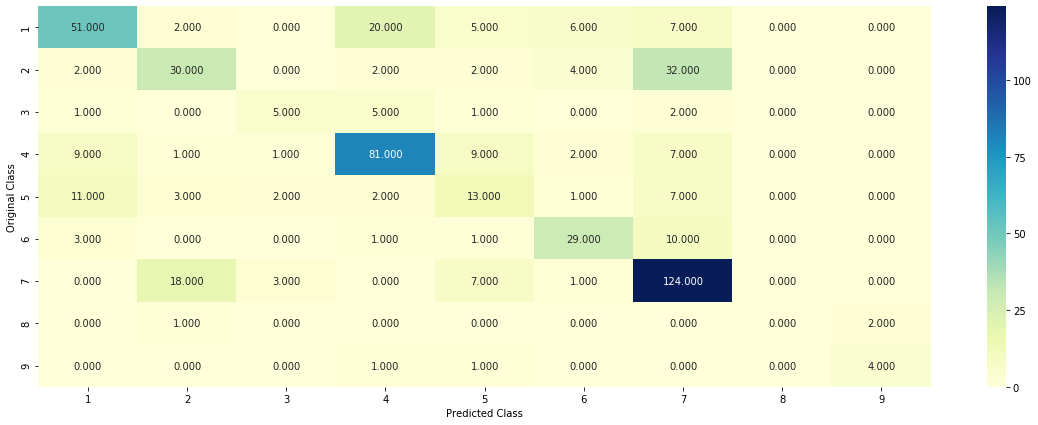

-------------------- Precision matrix (Columm Sum=1) --------------------


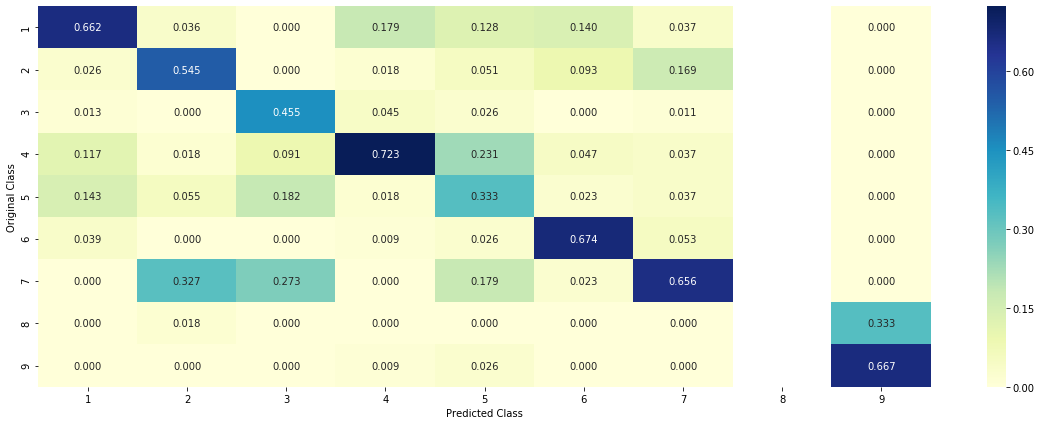

-------------------- Recall matrix (Row sum=1) --------------------


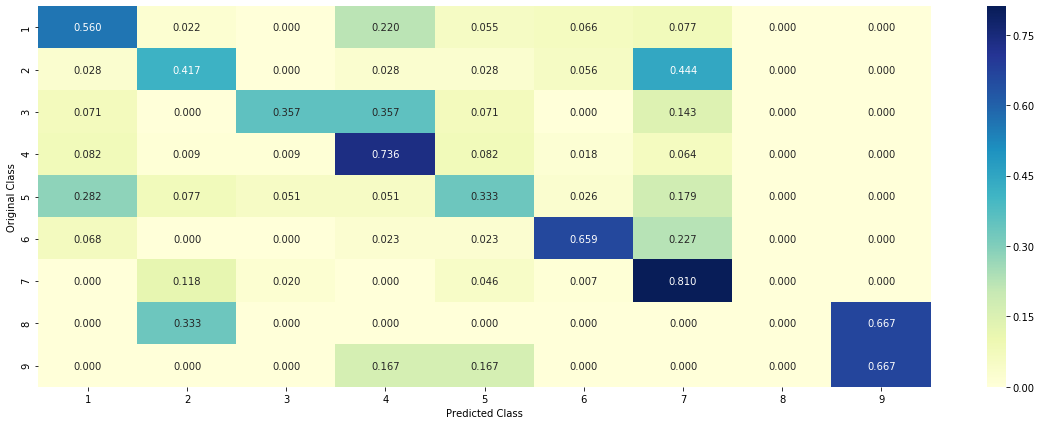

In [67]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced', n_jobs=-1)
predict_and_plot_confusion_matrix(train_x, train_y,cv_x,cv_y, clf)

<h2>Random Forest Classifier</h2>

<h3>Hyper parameter tuning</h3>

In [71]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2097893929246453
for n_estimators = 100 and max depth =  10
Log Loss : 1.1505697688243566
for n_estimators = 200 and max depth =  5
Log Loss : 1.19516163049719
for n_estimators = 200 and max depth =  10
Log Loss : 1.1377533911026425
for n_estimators = 500 and max depth =  5
Log Loss : 1.1839467340693997
for n_estimators = 500 and max depth =  10
Log Loss : 1.1307221658733373
for n_estimators = 1000 and max depth =  5
Log Loss : 1.179317807935621
for n_estimators = 1000 and max depth =  10
Log Loss : 1.13160805429713
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1773078725667965
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1311655383892472
For values of best estimator =  500 The train log loss is: 0.6683252479436504
For values of best estimator =  500 The cross validation log loss is: 1.1307221658733373
For values of best estimator =  500 The test log loss is: 1.1304160684898321


<h3>Testing model with best hyper parameters</h3>

Log loss : 1.1307221658733373
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


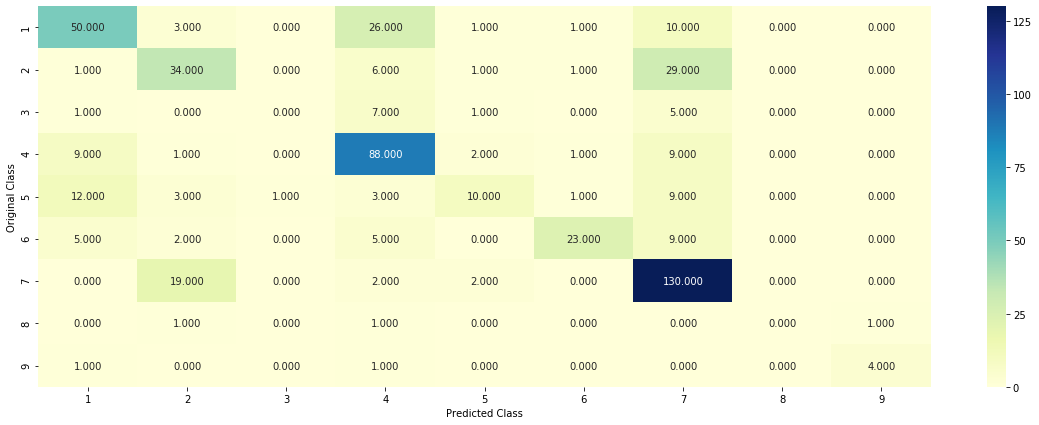

-------------------- Precision matrix (Columm Sum=1) --------------------


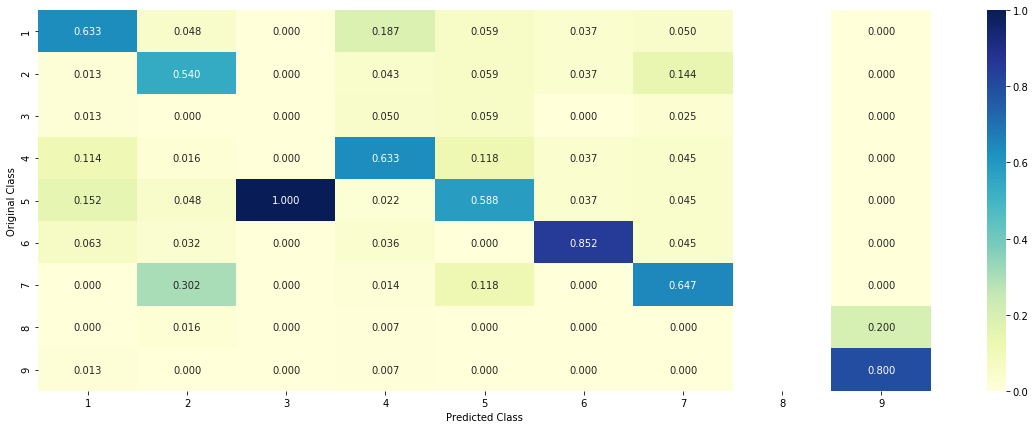

-------------------- Recall matrix (Row sum=1) --------------------


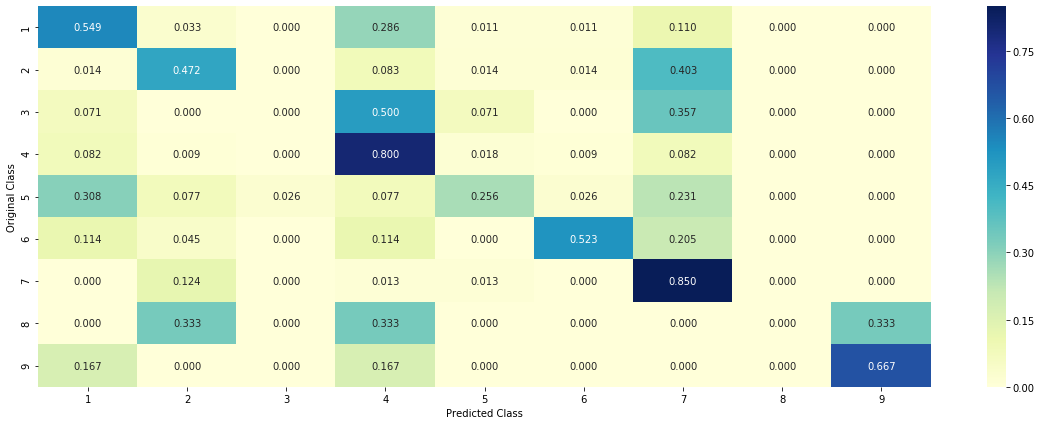

In [72]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x, train_y,cv_x,cv_y, clf)

<h2>Stack the models </h2>

<h3>Testing with hyper parameter tuning</h3>

In [77]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0, n_jobs=-1)
clf1.fit(train_x, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0, n_jobs=-1)
clf2.fit(train_x, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x))))
sig_clf2.fit(train_x, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x))))
sig_clf3.fit(train_x, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.06
Support vector machines : Log Loss: 1.43
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.033
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.494
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.124
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.242
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.539


<h3>Testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.629465133788593
Log loss (CV) on the stacking classifier : 1.1235712900342936
Log loss (test) on the stacking classifier : 1.0508511485256222
Number of missclassified point : 0.3323308270676692
-------------------- Confusion matrix --------------------


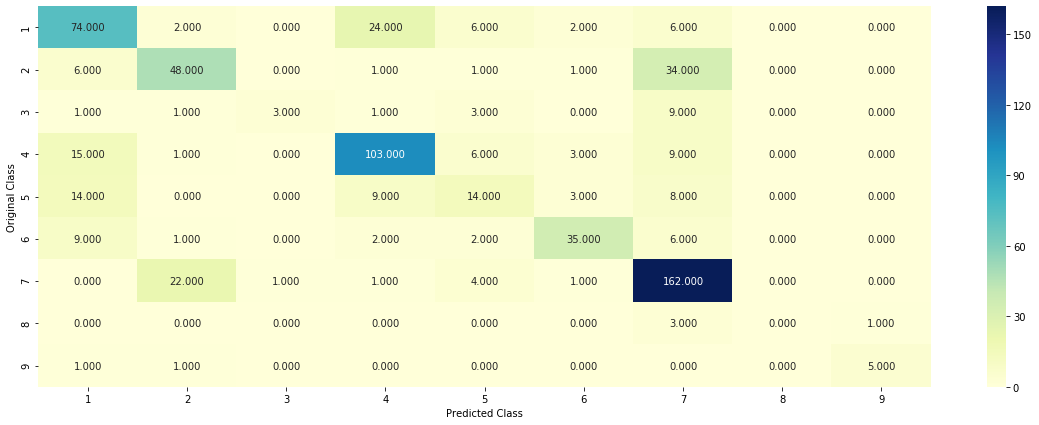

-------------------- Precision matrix (Columm Sum=1) --------------------


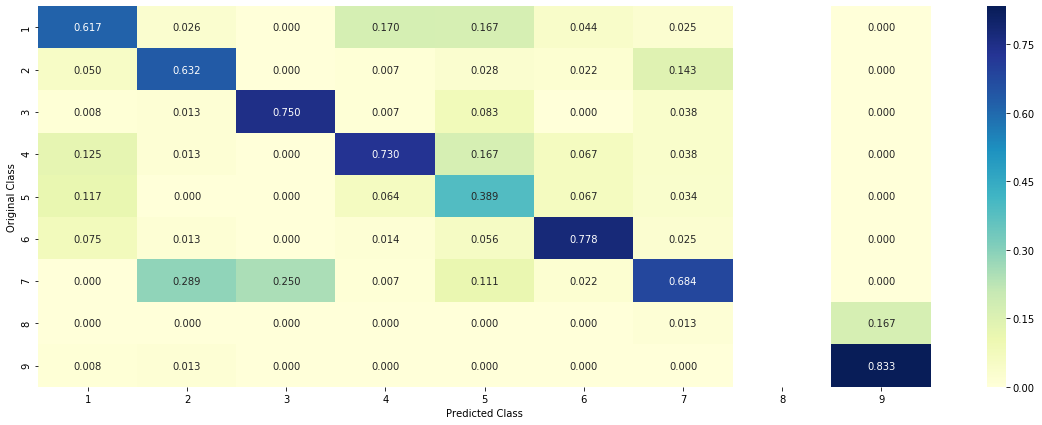

-------------------- Recall matrix (Row sum=1) --------------------


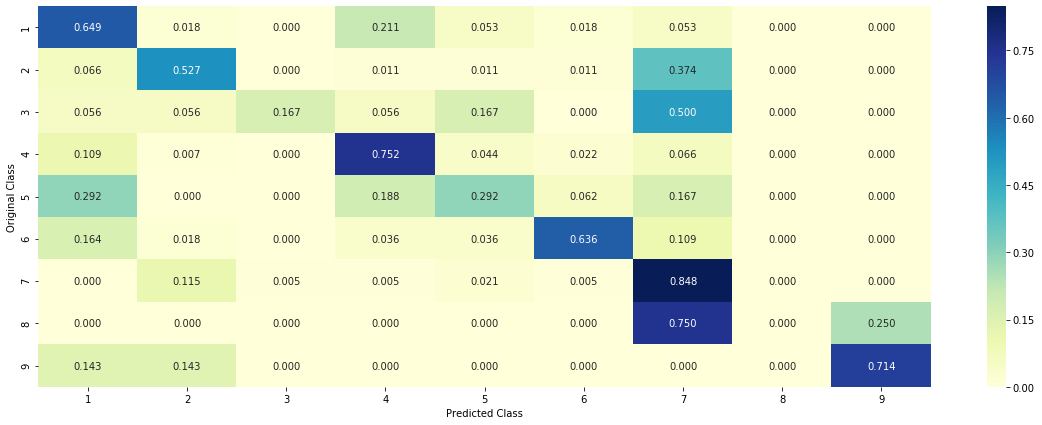

In [78]:
lr = LogisticRegression(C=0.1, n_jobs=-1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x))

<h3>Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8514271761568475
Log loss (CV) on the VotingClassifier : 1.132726702049288
Log loss (test) on the VotingClassifier : 1.1002680535265503
Number of missclassified point : 0.3308270676691729
-------------------- Confusion matrix --------------------


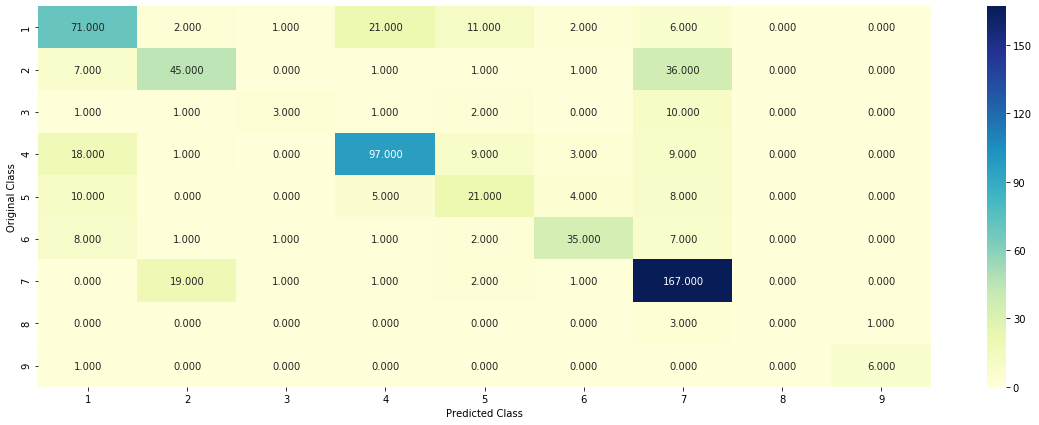

-------------------- Precision matrix (Columm Sum=1) --------------------


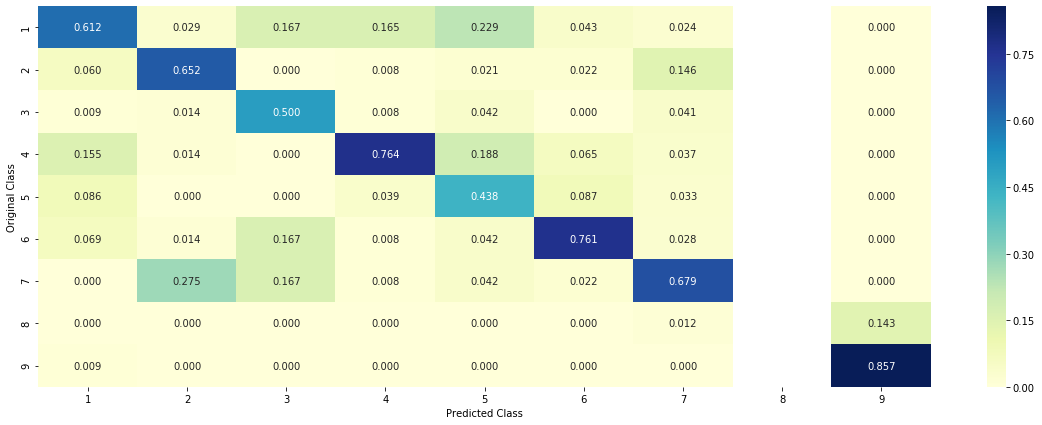

-------------------- Recall matrix (Row sum=1) --------------------


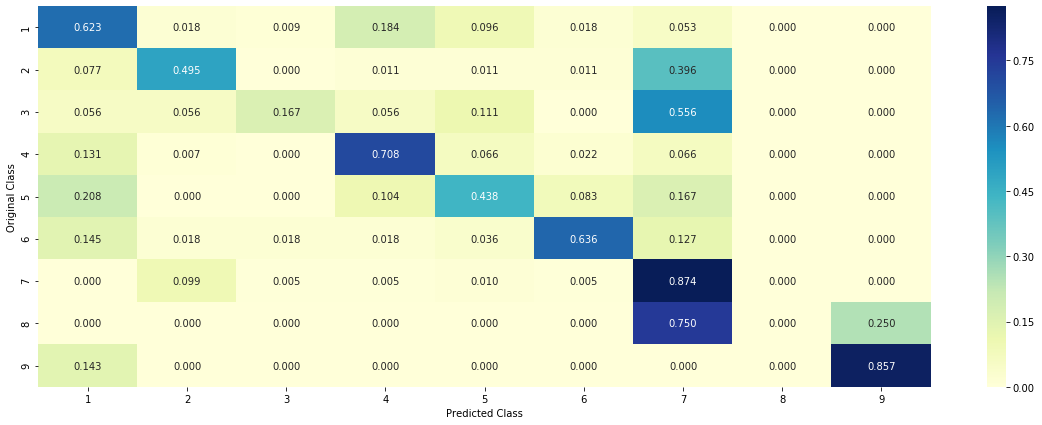

In [79]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft', n_jobs=-1)
vclf.fit(train_x, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x))

## TASK 2: Instead of using all the words in the dataset, use only the top 1000 words based of tf-idf values

In [17]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [18]:
text_vectorizer = TfidfVectorizer(min_df=3, max_features=1000)
train_text_feature_tfidfCoding_mf = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_tfidfCoding_mf.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [19]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))

total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [20]:
train_text_feature_tfidfCoding_mf = normalize(train_text_feature_tfidfCoding_mf, axis=0)
test_text_feature_tfidfCoding_mf = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidfCoding_mf = normalize(test_text_feature_tfidfCoding_mf, axis=0)
cv_text_feature_tfidfCoding_mf = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidfCoding_mf = normalize(cv_text_feature_tfidfCoding_mf, axis=0)

In [21]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [22]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_mf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidfCoding_mf)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_mf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidfCoding_mf)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_mf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidfCoding_mf)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [23]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_mf.shape)
print("(number of data points * number of features) in test data = ", test_x_mf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_mf.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3194)
(number of data points * number of features) in test data =  (665, 3194)
(number of data points * number of features) in cross validation data = (532, 3194)


<h3>Naive Bayes</h3>

<h4>Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.235623398276829
for alpha = 0.0001
Log Loss : 1.237468144672753
for alpha = 0.001
Log Loss : 1.2362445405342497
for alpha = 0.1
Log Loss : 1.2779210952574418
for alpha = 1
Log Loss : 1.3282469663807541
for alpha = 10
Log Loss : 1.5633808570012424
for alpha = 100
Log Loss : 1.5548274567058655
for alpha = 1000
Log Loss : 1.5418702122102992


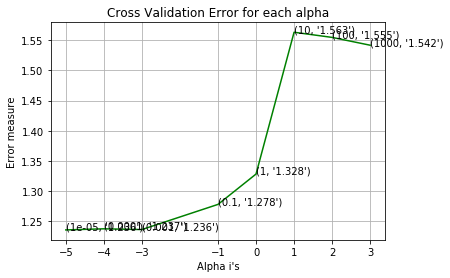

For values of best alpha =  1e-05 The train log loss is: 0.5156293426741223
For values of best alpha =  1e-05 The cross validation log loss is: 1.235623398276829
For values of best alpha =  1e-05 The test log loss is: 1.2375548871934285


In [24]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_mf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_mf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_mf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)


predict_y = sig_clf.predict_proba(train_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>Testing the model with best hyper paramters</h4>

Log Loss : 1.235623398276829
Number of missclassified point : 0.40601503759398494
-------------------- Confusion matrix --------------------


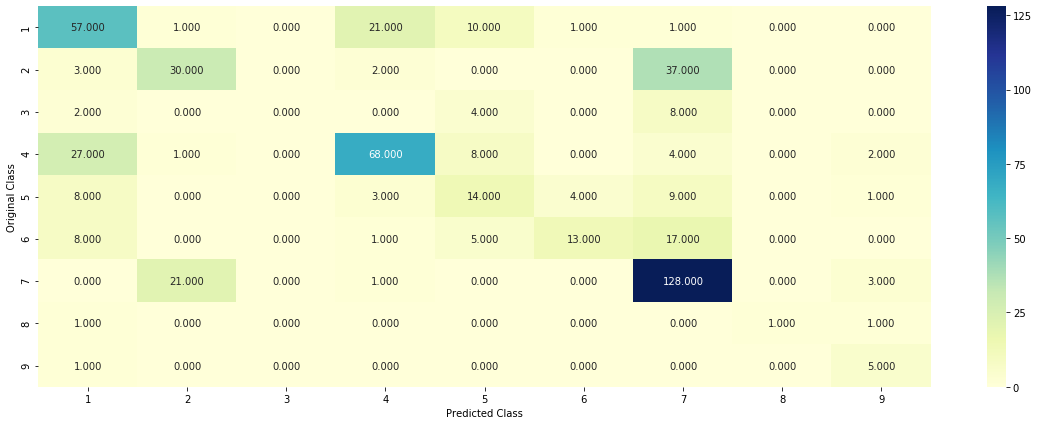

-------------------- Precision matrix (Columm Sum=1) --------------------


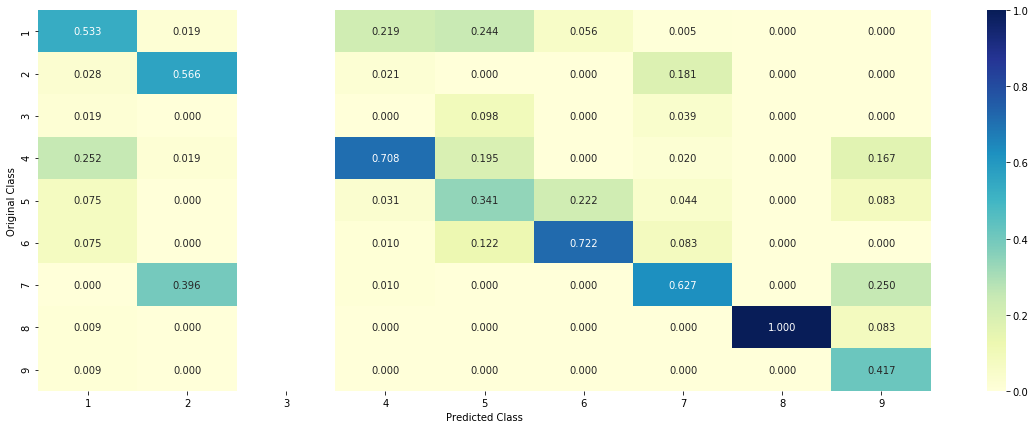

-------------------- Recall matrix (Row sum=1) --------------------


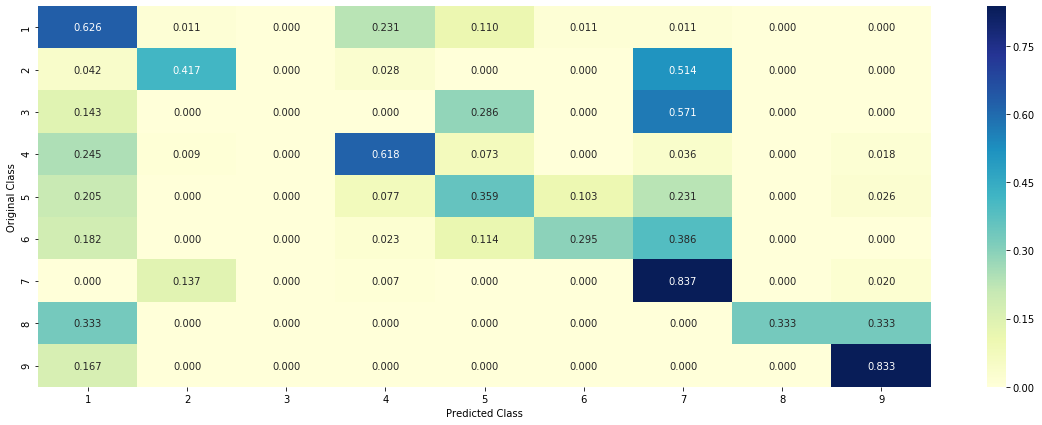

In [28]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_mf)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_mf)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_mf.toarray()))

<h2>K Nearest Neighbour Classification</h2>

<h3>Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.1380188026393696
for alpha = 11
Log Loss : 1.1526240167437987
for alpha = 15
Log Loss : 1.1653809036471106
for alpha = 21
Log Loss : 1.1787070070293786
for alpha = 31
Log Loss : 1.2042056001477033
for alpha = 41
Log Loss : 1.2259067602645954
for alpha = 51
Log Loss : 1.2447977933632406
for alpha = 99
Log Loss : 1.310811688564303


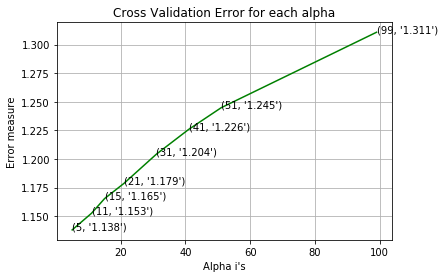

For values of best alpha =  5 The train log loss is: 0.8677739141487583
For values of best alpha =  5 The cross validation log loss is: 1.1380188026393696
For values of best alpha =  5 The test log loss is: 1.100439299591457


In [31]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    clf.fit(train_x_mf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_mf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_mf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)

predict_y = sig_clf.predict_proba(train_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>Testing the model with best hyper paramters</h3>

Log loss : 1.1380188026393696
Number of mis-classified points : 0.38721804511278196
-------------------- Confusion matrix --------------------


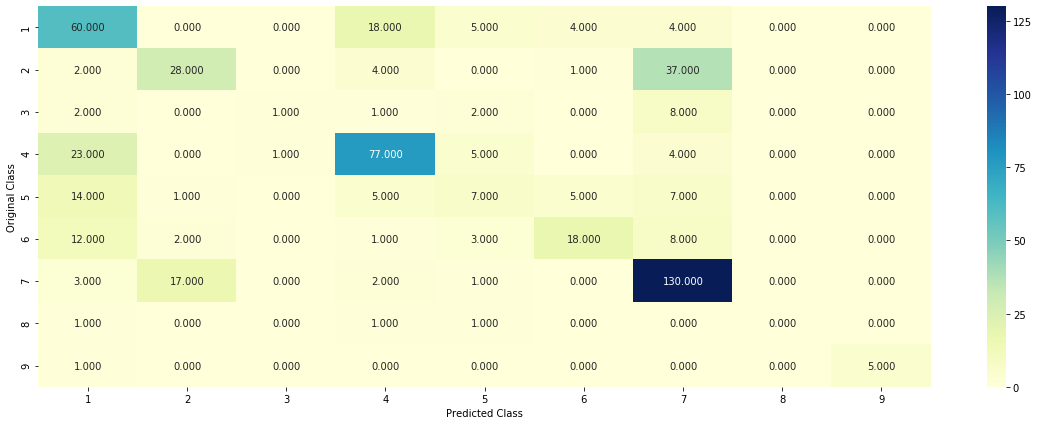

-------------------- Precision matrix (Columm Sum=1) --------------------


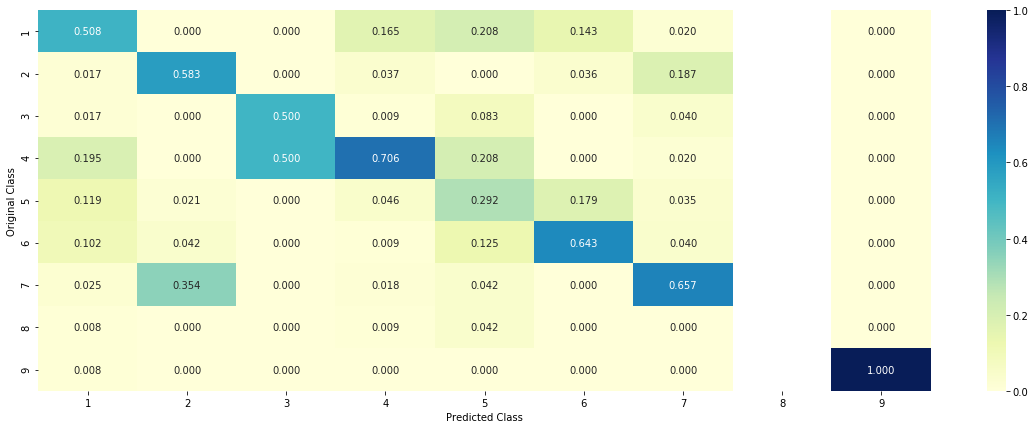

-------------------- Recall matrix (Row sum=1) --------------------


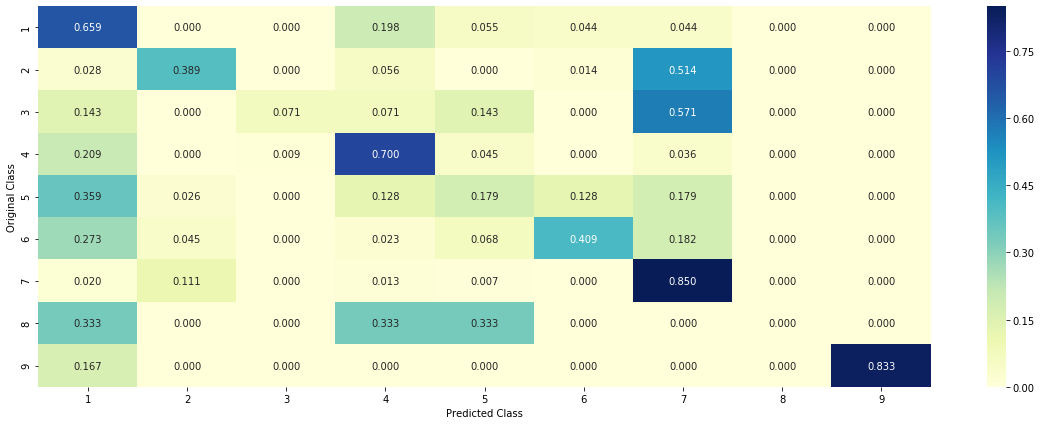

In [32]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_mf, train_y, cv_x_mf, cv_y, clf)

<h3>Sample Query point -1</h3>

In [33]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_mf[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_mf[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 1
The  5  nearest neighbours of the test points belongs to classes [5 5 1 1 4]
Fequency of nearest points : Counter({5: 2, 1: 2, 4: 1})


<h3>Sample Query Point-2 </h3>

In [34]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_mf[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_mf[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 6
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [6 6 6 6 6]
Fequency of nearest points : Counter({6: 5})


<h2>Logistic Regression</h2>

<h3>With Class balancing</h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.2156470316013581
for alpha = 1e-05
Log Loss : 1.1263344400505
for alpha = 0.0001
Log Loss : 1.051147736066092
for alpha = 0.001
Log Loss : 1.0475720521859284
for alpha = 0.01
Log Loss : 1.2142881734686208
for alpha = 0.1
Log Loss : 1.6543674942060125
for alpha = 1
Log Loss : 1.7909549451107525
for alpha = 10
Log Loss : 1.805454128584691
for alpha = 100
Log Loss : 1.807089207165866


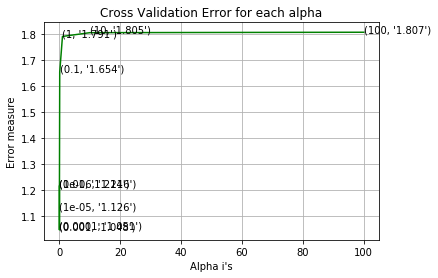

For values of best alpha =  0.001 The train log loss is: 0.7212432243763777
For values of best alpha =  0.001 The cross validation log loss is: 1.0475720521859284
For values of best alpha =  0.001 The test log loss is: 1.0653477884592335


In [35]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_x_mf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_mf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_mf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)

predict_y = sig_clf.predict_proba(train_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing the model with best hyper paramters</h4>

Log loss : 1.0475720521859284
Number of mis-classified points : 0.38533834586466165
-------------------- Confusion matrix --------------------


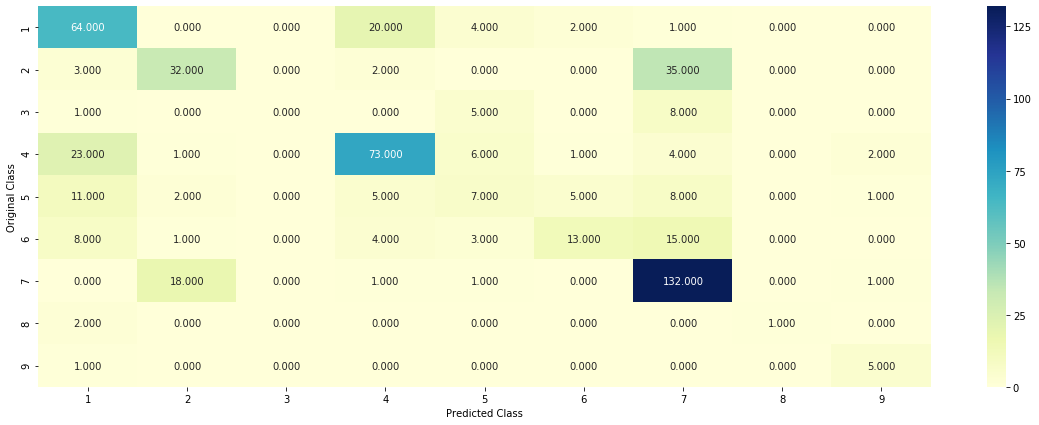

-------------------- Precision matrix (Columm Sum=1) --------------------


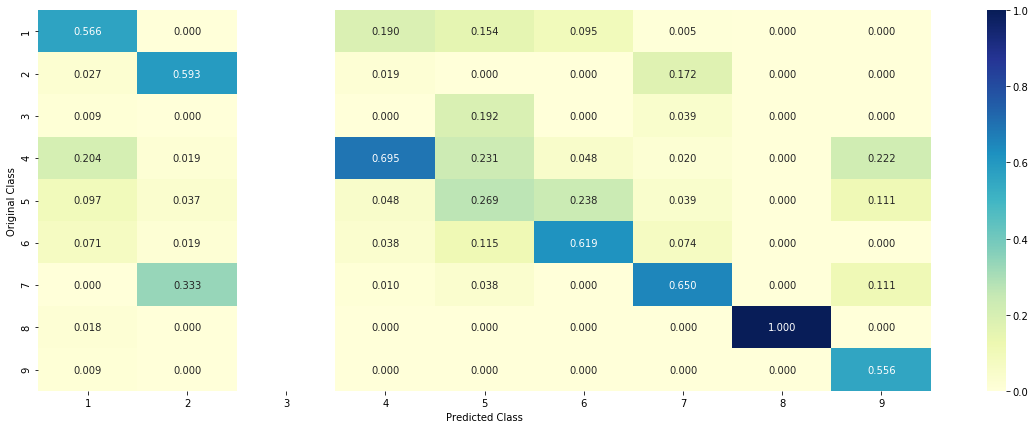

-------------------- Recall matrix (Row sum=1) --------------------


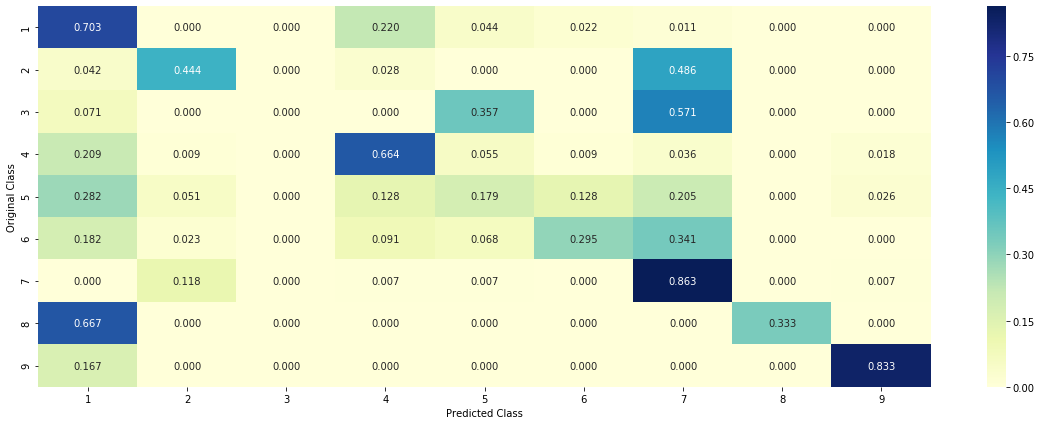

In [36]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_mf, train_y, cv_x_mf, cv_y, clf)

In [37]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h3>Without Class balancing</h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.2185088986072765
for alpha = 1e-05
Log Loss : 1.139549364892308
for alpha = 0.0001
Log Loss : 1.0818999380261674
for alpha = 0.001
Log Loss : 1.1588893414906214
for alpha = 0.01
Log Loss : 1.3107461821484587
for alpha = 0.1
Log Loss : 1.5921129797630686
for alpha = 1
Log Loss : 1.7263931454073829


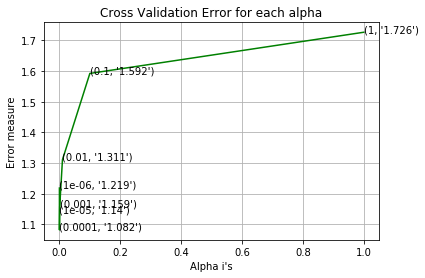

For values of best alpha =  0.0001 The train log loss is: 0.43216856545262194
For values of best alpha =  0.0001 The cross validation log loss is: 1.0818999380261674
For values of best alpha =  0.0001 The test log loss is: 1.03755624379752


In [40]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_x_mf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_mf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_mf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)

predict_y = sig_clf.predict_proba(train_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing model with best hyper parameters</h4>

Log loss : 1.0818999380261674
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


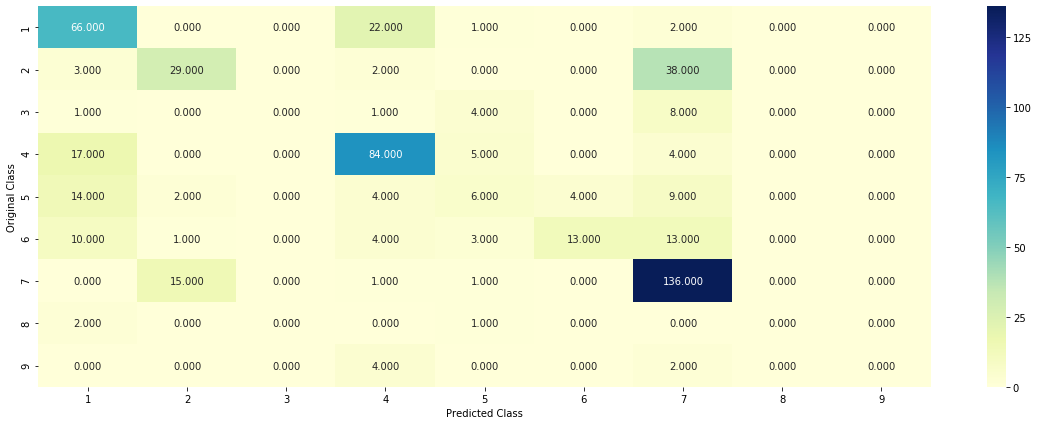

-------------------- Precision matrix (Columm Sum=1) --------------------


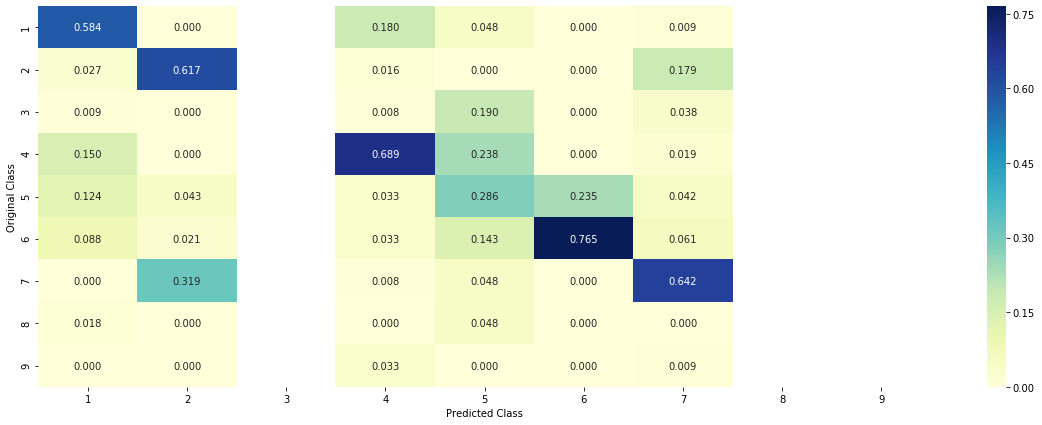

-------------------- Recall matrix (Row sum=1) --------------------


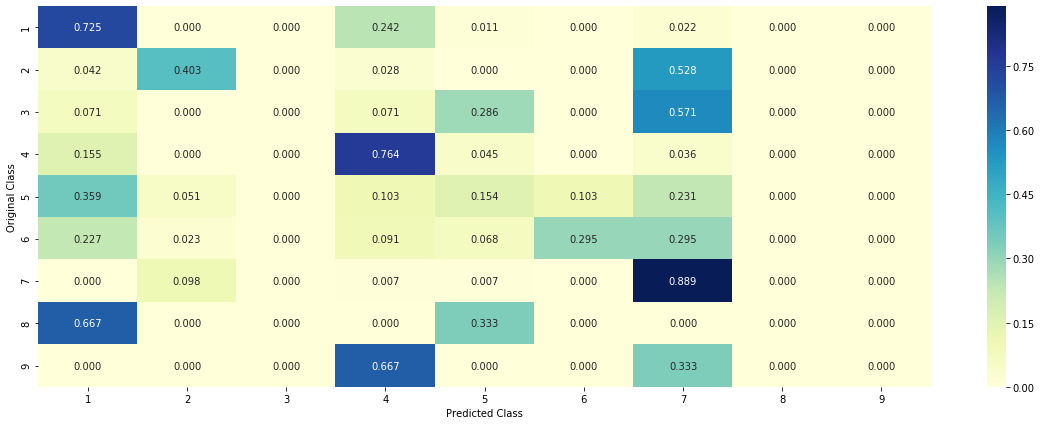

In [41]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_mf, train_y, cv_x_mf, cv_y, clf)

<h2>Linear Support Vector Machines</h2>

<h3>Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.1579521585239805
for C = 0.0001
Log Loss : 1.1026449615997873
for C = 0.001
Log Loss : 1.113046317860601
for C = 0.01
Log Loss : 1.3739444471843452
for C = 0.1
Log Loss : 1.6681818187727249
for C = 1
Log Loss : 1.8074538962695244
for C = 10
Log Loss : 1.8074539410292907
for C = 100
Log Loss : 1.8074539548001742


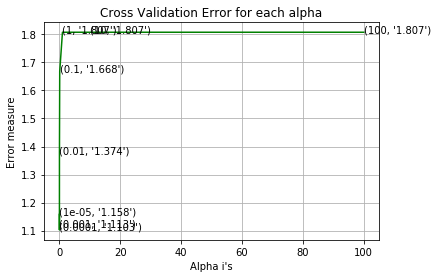

For values of best alpha =  0.0001 The train log loss is: 0.39331758679681766
For values of best alpha =  0.0001 The cross validation log loss is: 1.1026449615997873
For values of best alpha =  0.0001 The test log loss is: 1.0462470410979117


In [44]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42, n_jobs=-1)
    clf.fit(train_x_mf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_mf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_mf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, n_jobs=-1)
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)

predict_y = sig_clf.predict_proba(train_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_mf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>Testing model with best hyper parameters</h3>

Log loss : 1.1026449615997873
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


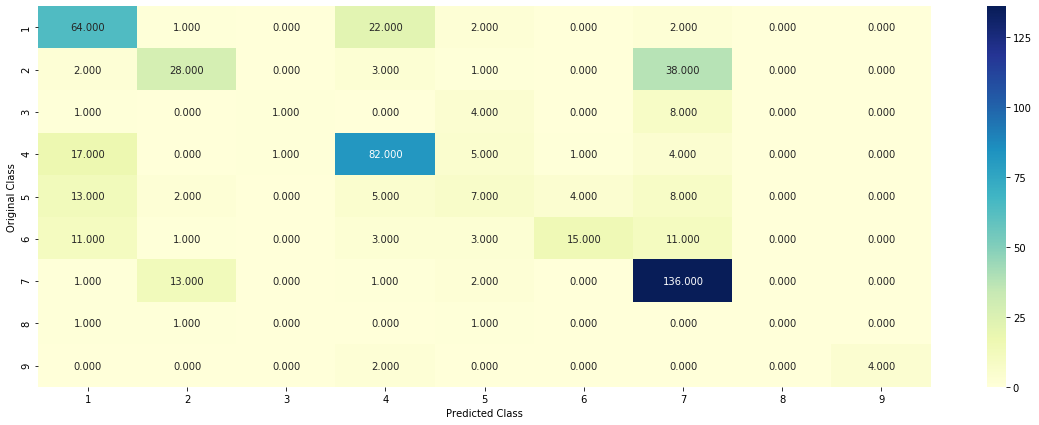

-------------------- Precision matrix (Columm Sum=1) --------------------


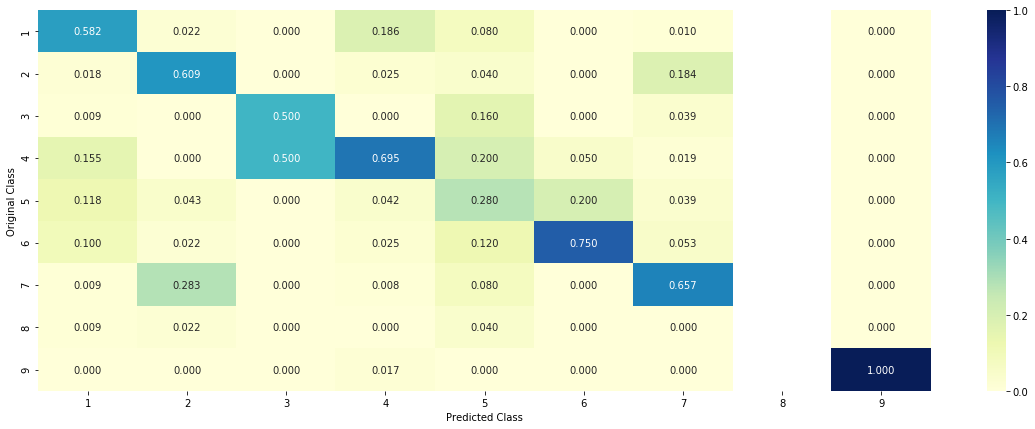

-------------------- Recall matrix (Row sum=1) --------------------


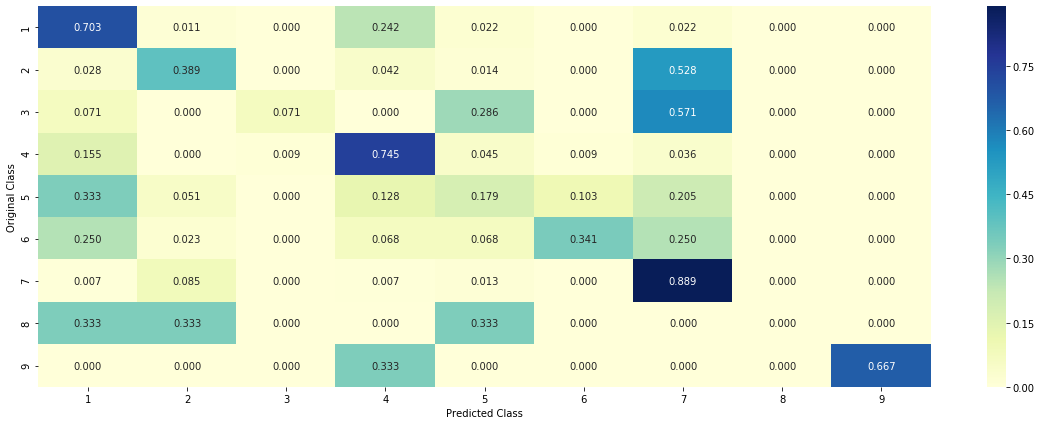

In [45]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced', n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_mf, train_y,cv_x_mf,cv_y, clf)

<h2>Random Forest Classifier</h2>

<h3>Hyper parameter tuning</h3>

In [48]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_mf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_mf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_mf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_mf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_mf, train_y)

predict_y = sig_clf.predict_proba(train_x_mf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_mf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_mf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.267490766107194
for n_estimators = 100 and max depth =  10
Log Loss : 1.2863826682063193
for n_estimators = 200 and max depth =  5
Log Loss : 1.2515136566174618
for n_estimators = 200 and max depth =  10
Log Loss : 1.2758085232761727
for n_estimators = 500 and max depth =  5
Log Loss : 1.238360835016574
for n_estimators = 500 and max depth =  10
Log Loss : 1.281572431935243
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2381031361104682
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2785955815719454
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2400692234094497
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2771458817084913
For values of best estimator =  1000 The train log loss is: 0.8613815751102593
For values of best estimator =  1000 The cross validation log loss is: 1.2381031403676173
For values of best estimator =  1000 The test log loss is: 1.1898416048375262


<h3>Testing model with best hyper parameters</h3>

Log loss : 1.2381031855647018
Number of mis-classified points : 0.45112781954887216
-------------------- Confusion matrix --------------------


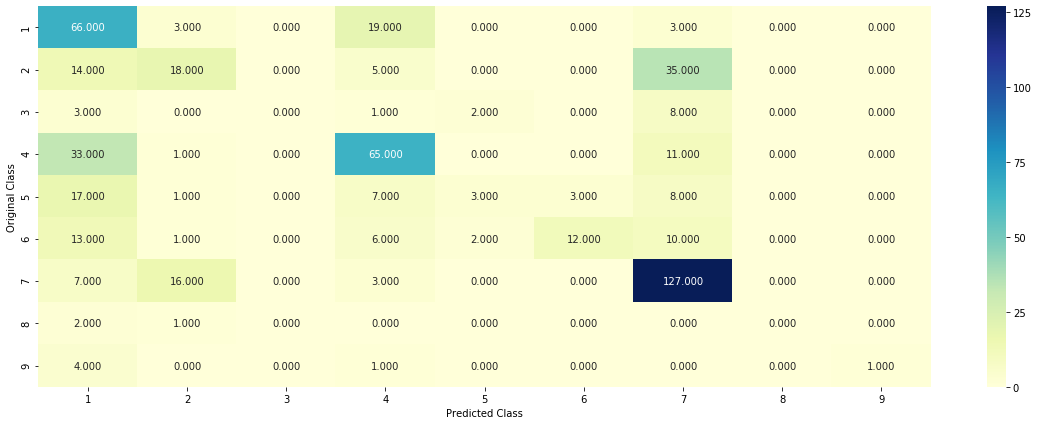

-------------------- Precision matrix (Columm Sum=1) --------------------


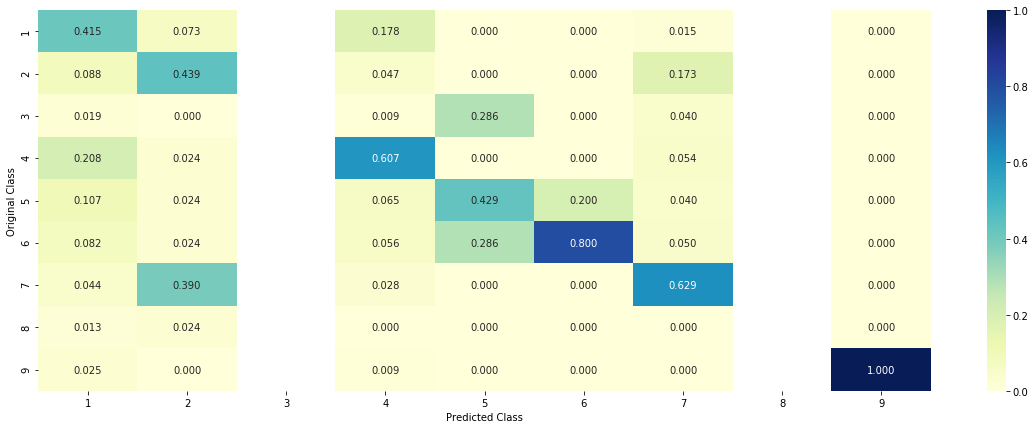

-------------------- Recall matrix (Row sum=1) --------------------


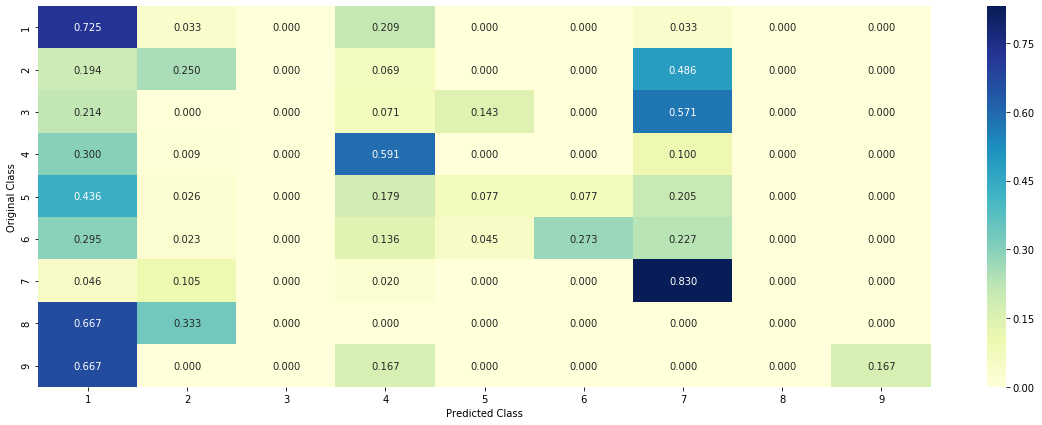

In [49]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_mf, train_y,cv_x_mf,cv_y, clf)

<h2>Stack the models </h2>

<h3>Testing with hyper parameter tuning</h3>

In [52]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0, n_jobs=-1)
clf1.fit(train_x_mf, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0, n_jobs=-1)
clf2.fit(train_x_mf, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_mf, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_mf, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_mf))))
sig_clf2.fit(train_x_mf, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_mf))))
sig_clf3.fit(train_x_mf, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_mf))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_mf, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_mf))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_mf))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.05
Support vector machines : Log Loss: 1.81
Naive Bayes : Log Loss: 1.24
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.177
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.030
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.501
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.208
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.464
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.969


<h3>Testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.537394497571305
Log loss (CV) on the stacking classifier : 1.2083962755695077
Log loss (test) on the stacking classifier : 1.2310730153093201
Number of missclassified point : 0.3969924812030075
-------------------- Confusion matrix --------------------


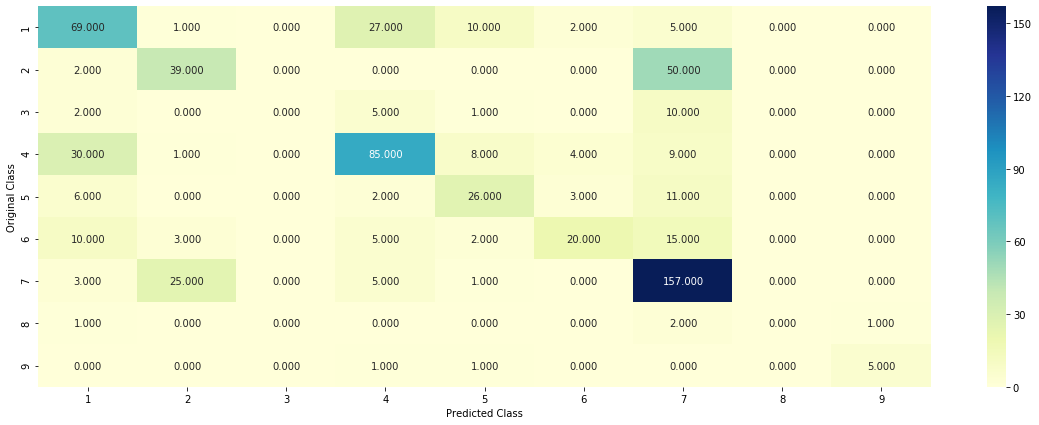

-------------------- Precision matrix (Columm Sum=1) --------------------


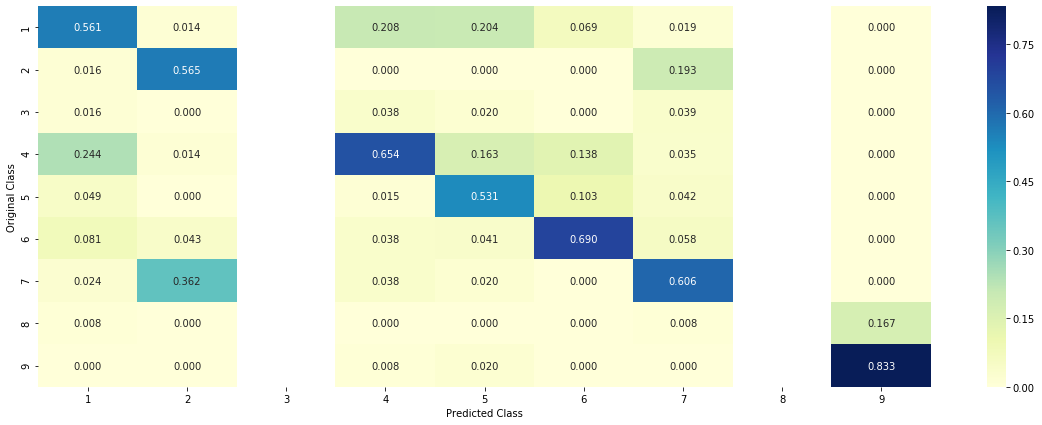

-------------------- Recall matrix (Row sum=1) --------------------


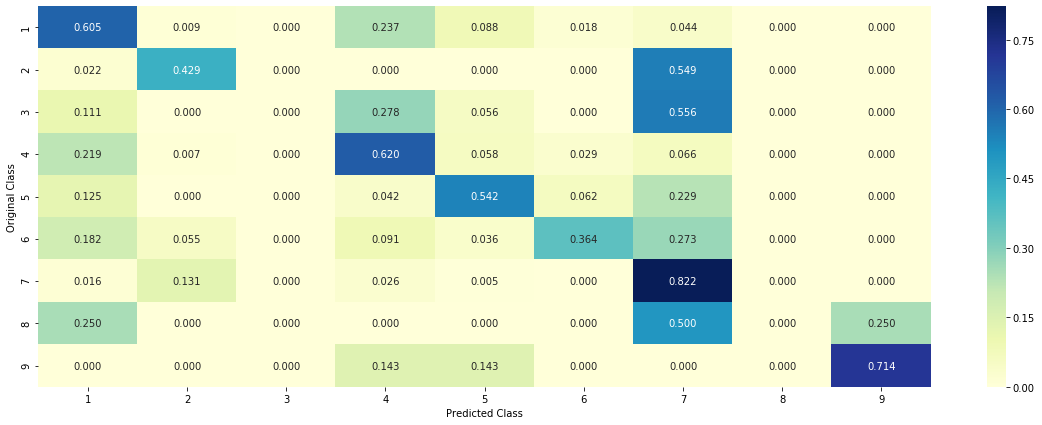

In [53]:
lr = LogisticRegression(C=0.1, n_jobs=-1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_mf, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_mf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_mf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_mf))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_mf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_mf))

<h3>Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8220149616770289
Log loss (CV) on the VotingClassifier : 1.2209805250513084
Log loss (test) on the VotingClassifier : 1.2156890450368238
Number of missclassified point : 0.3849624060150376
-------------------- Confusion matrix --------------------


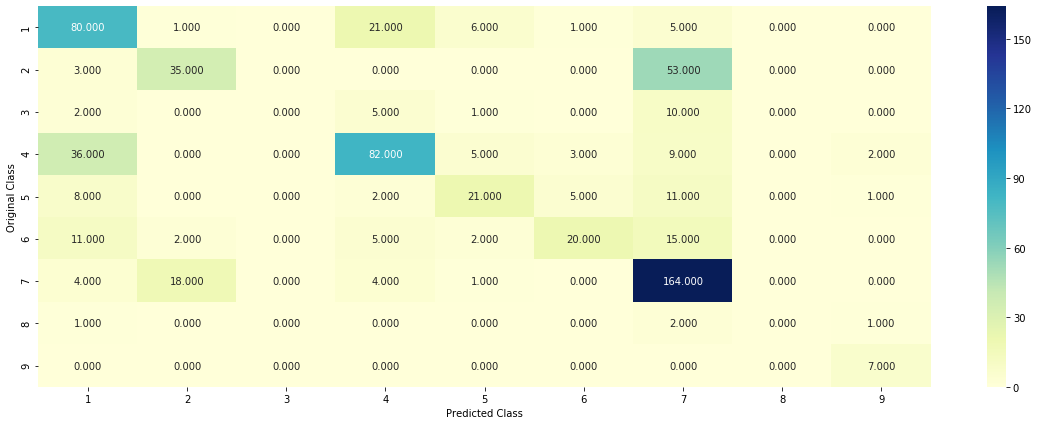

-------------------- Precision matrix (Columm Sum=1) --------------------


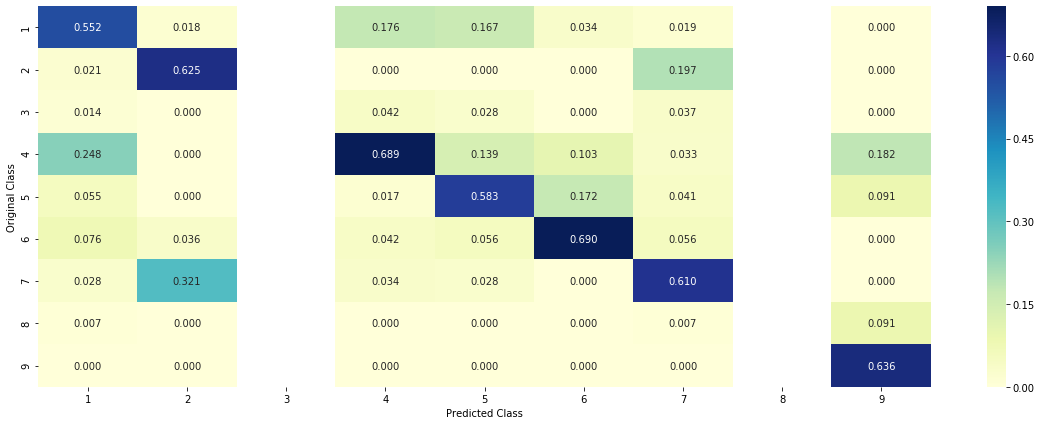

-------------------- Recall matrix (Row sum=1) --------------------


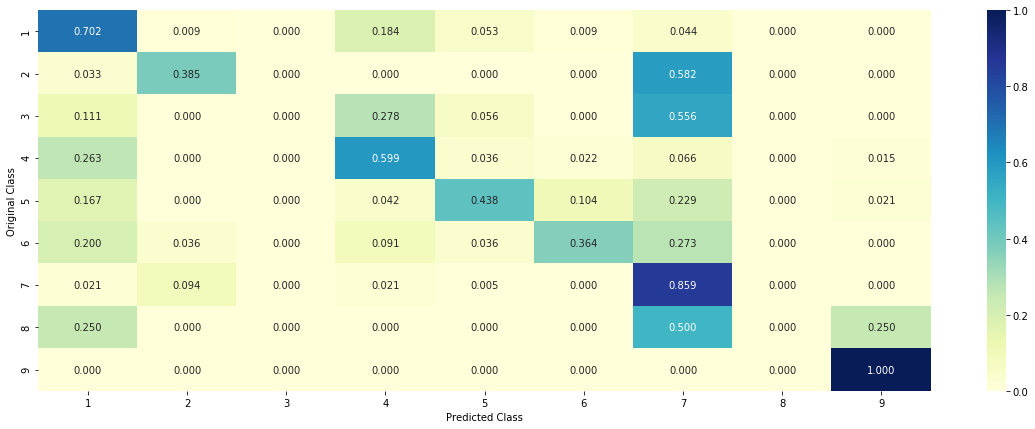

In [54]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft', n_jobs=-1)
vclf.fit(train_x_mf, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_mf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_mf)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_mf)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_mf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_mf))

## TASK 3: Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams

In [14]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [15]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [16]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [27]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3, ngram_range=(1,2))
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [18]:
text_vectorizer = CountVectorizer(min_df=3, ngram_range=(1,2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 769202


In [19]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))
total_dict = extract_dictionary_paddle(train_df)
confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [20]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [21]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

<h2>Logistic Regression</h2>

<h3>With Class balancing</h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.5315997228661131
for alpha = 1e-05
Log Loss : 1.5032395476038702
for alpha = 0.0001
Log Loss : 1.4537615866208713
for alpha = 0.001
Log Loss : 1.1985385103709656
for alpha = 0.01
Log Loss : 1.1597451970457147
for alpha = 0.1
Log Loss : 1.1876858182112198
for alpha = 1
Log Loss : 1.2744181471940252
for alpha = 10
Log Loss : 1.3563330596123642
for alpha = 100
Log Loss : 1.37450170243142


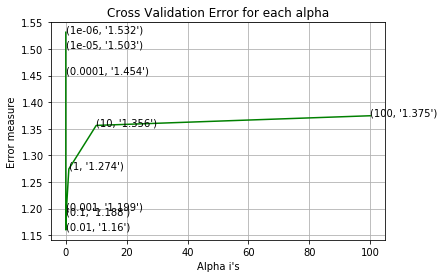

For values of best alpha =  0.01 The train log loss is: 0.7341443889981226
For values of best alpha =  0.01 The cross validation log loss is: 1.1597451970457147
For values of best alpha =  0.01 The test log loss is: 1.1532261823941004


In [22]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing the model with best hyper paramters</h4>

Log loss : 1.1597451970457147
Number of mis-classified points : 0.40037593984962405
-------------------- Confusion matrix --------------------


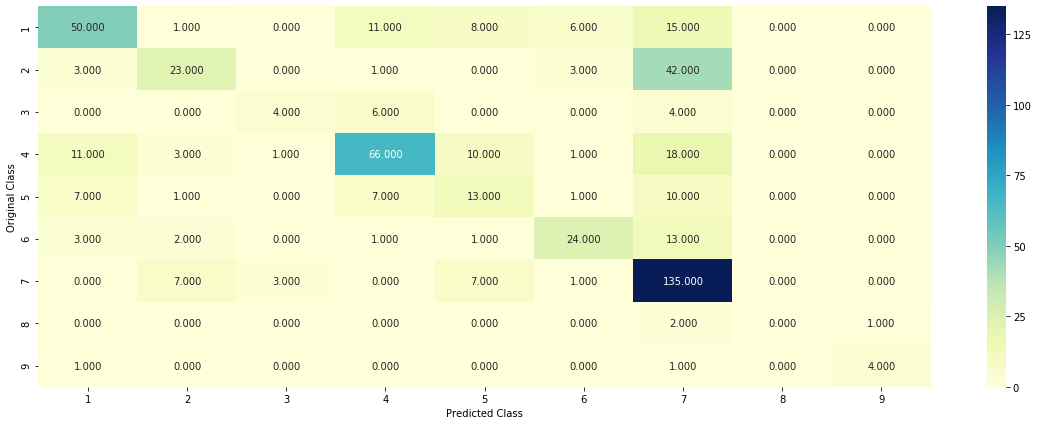

-------------------- Precision matrix (Columm Sum=1) --------------------


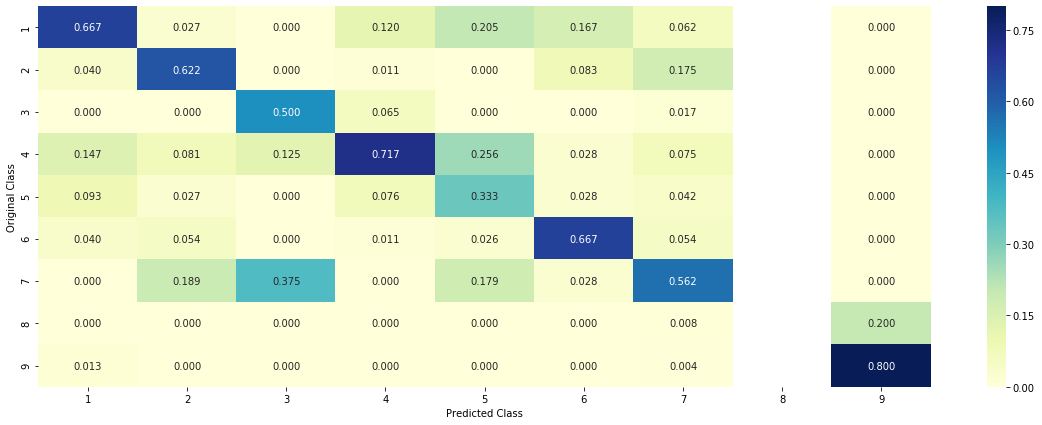

-------------------- Recall matrix (Row sum=1) --------------------


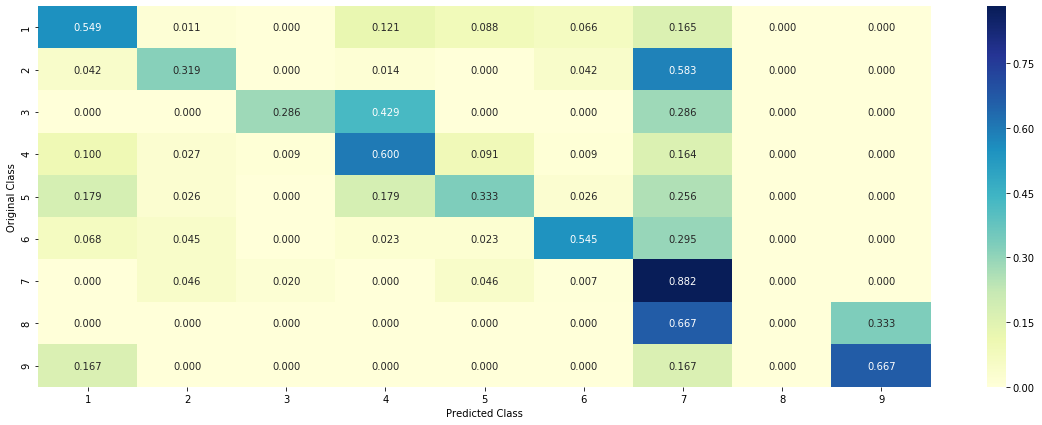

In [23]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [24]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h3>Without Class balancing</h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.4786694317974693
for alpha = 1e-05
Log Loss : 1.4841132455418107
for alpha = 0.0001
Log Loss : 1.423953663392474
for alpha = 0.001
Log Loss : 1.1881685643950906
for alpha = 0.01
Log Loss : 1.156941277151156
for alpha = 0.1
Log Loss : 1.184130317154827
for alpha = 1
Log Loss : 1.273091373298051


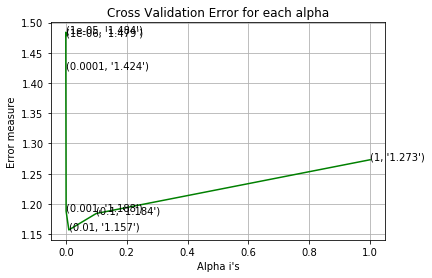

For values of best alpha =  0.01 The train log loss is: 0.7253217180872641
For values of best alpha =  0.01 The cross validation log loss is: 1.156941277151156
For values of best alpha =  0.01 The test log loss is: 1.151496194890429


In [30]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing model with best hyper parameters</h4>

Log loss : 1.156941277151156
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


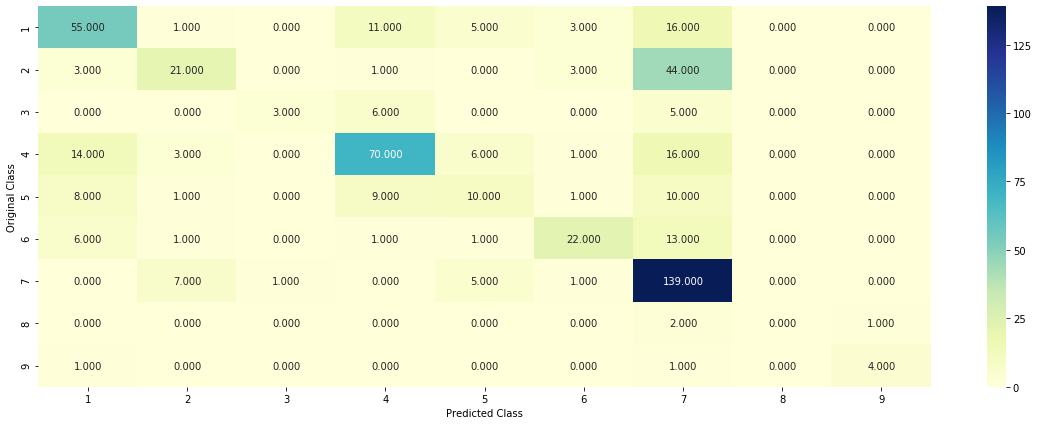

-------------------- Precision matrix (Columm Sum=1) --------------------


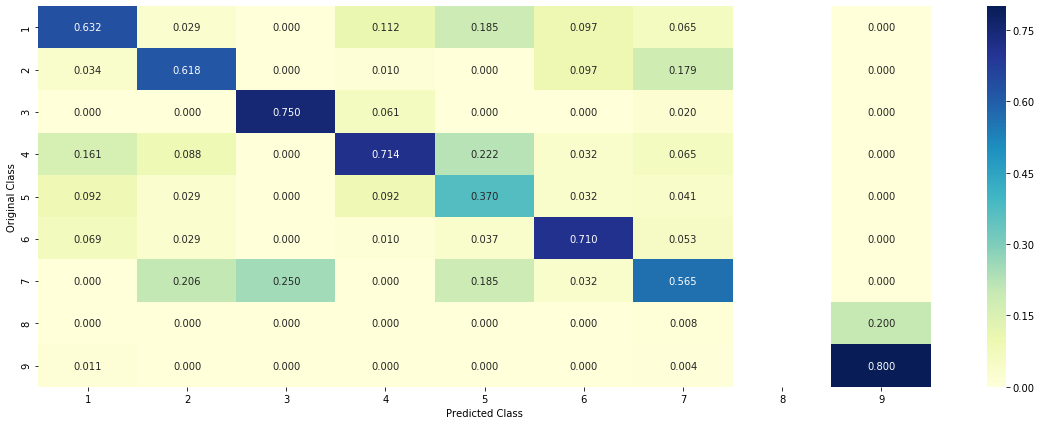

-------------------- Recall matrix (Row sum=1) --------------------


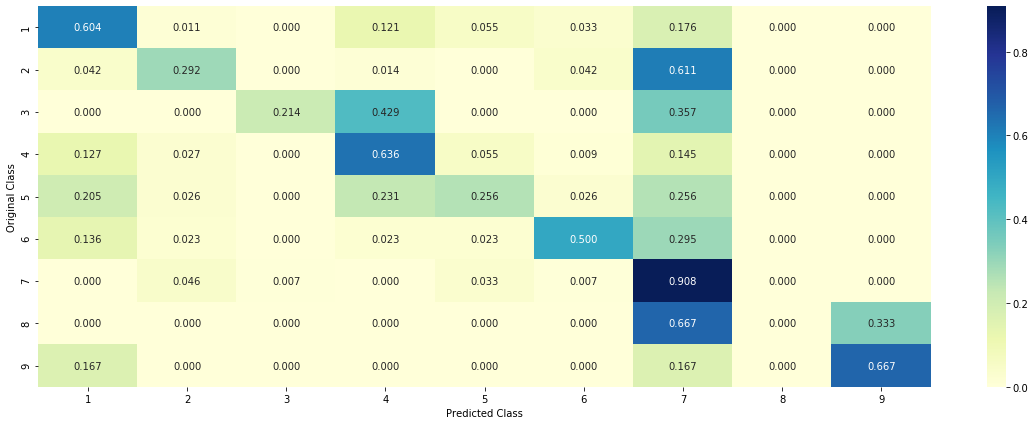

In [31]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## TASK 4: Try any of the feature engineering techniques discussed in the course to reduce the CV and test log-loss to a value less than 1.0

In [33]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [54]:
text_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,4), max_features=2000)
train_text_feature_tfidfCoding_t4 = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_tfidfCoding_t4.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 2000


In [55]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))
total_dict = extract_dictionary_paddle(train_df)
confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [56]:
train_text_feature_tfidfCoding_t4 = normalize(train_text_feature_tfidfCoding_t4, axis=0)
test_text_feature_tfidfCoding_t4 = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidfCoding_t4 = normalize(test_text_feature_tfidfCoding_t4, axis=0)
cv_text_feature_tfidfCoding_t4 = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidfCoding_t4 = normalize(cv_text_feature_tfidfCoding_t4, axis=0)

In [57]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

For values of alpha =  1e-05 The log loss is: 1.2382906620464298
For values of alpha =  0.0001 The log loss is: 1.2809729125527025
For values of alpha =  0.001 The log loss is: 1.5435360794087059
For values of alpha =  0.01 The log loss is: 1.8291255220252105
For values of alpha =  0.1 The log loss is: 2.0300356728005613
For values of alpha =  1 The log loss is: 2.0213408213525437


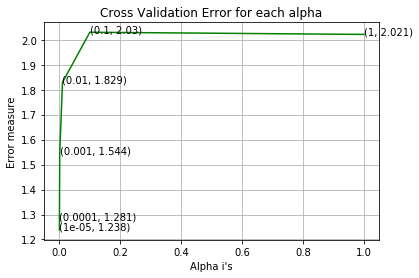

For values of best alpha =  1e-05 The train log loss is: 0.6866686301271799
For values of best alpha =  1e-05 The cross validation log loss is: 1.2382906620464298
For values of best alpha =  1e-05 The test log loss is: 1.08308895684138


In [58]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_text_feature_tfidfCoding_t4, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_tfidfCoding_t4, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_tfidfCoding_t4)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_text_feature_tfidfCoding_t4, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_tfidfCoding_t4, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_tfidfCoding_t4)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_tfidfCoding_t4)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_tfidfCoding_t4)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [59]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_t4 = hstack((train_gene_var_onehotCoding, train_text_feature_tfidfCoding_t4)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_t4 = hstack((test_gene_var_onehotCoding, test_text_feature_tfidfCoding_t4)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_t4 = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidfCoding_t4)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [60]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_t4.shape)
print("(number of data points * number of features) in test data = ", test_x_t4.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_t4.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 4177)
(number of data points * number of features) in test data =  (665, 4177)
(number of data points * number of features) in cross validation data = (532, 4177)


In [61]:
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3, ngram_range=(1,4))
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<h3>Naive Bayes</h3>

<h4>Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.2733438830973944
for alpha = 0.0001
Log Loss : 1.271708835331994
for alpha = 0.001
Log Loss : 1.270275604257013
for alpha = 0.1
Log Loss : 1.2683387979841616
for alpha = 1
Log Loss : 1.3641634663776012
for alpha = 10
Log Loss : 1.5557389221969773
for alpha = 100
Log Loss : 1.5460204516914138
for alpha = 1000
Log Loss : 1.5224371352338786


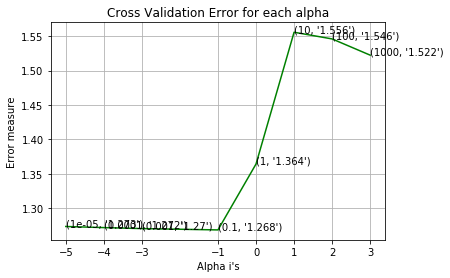

For values of best alpha =  0.1 The train log loss is: 0.7295978657020473
For values of best alpha =  0.1 The cross validation log loss is: 1.2683387979841616
For values of best alpha =  0.1 The test log loss is: 1.218202274235127


In [62]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_t4, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_t4, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_t4)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)


predict_y = sig_clf.predict_proba(train_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>Testing the model with best hyper paramters</h4>

Log Loss : 1.2683387979841616
Number of missclassified point : 0.3966165413533835
-------------------- Confusion matrix --------------------


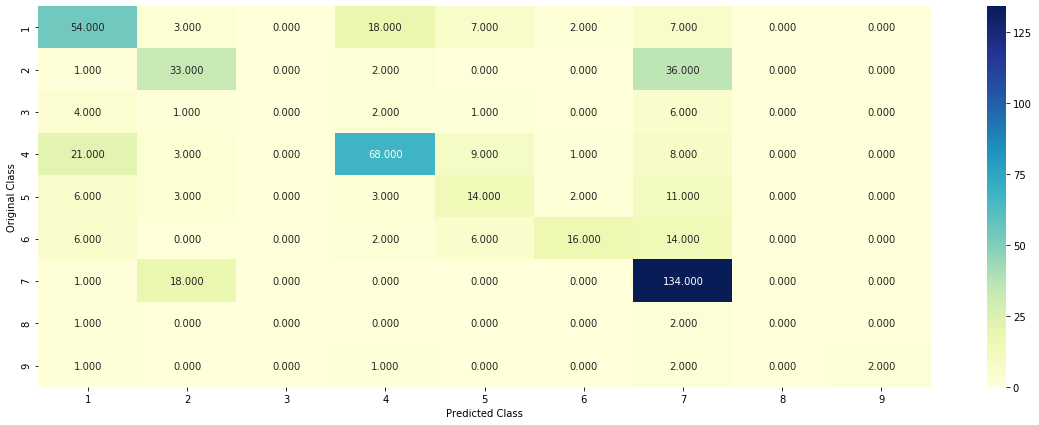

-------------------- Precision matrix (Columm Sum=1) --------------------


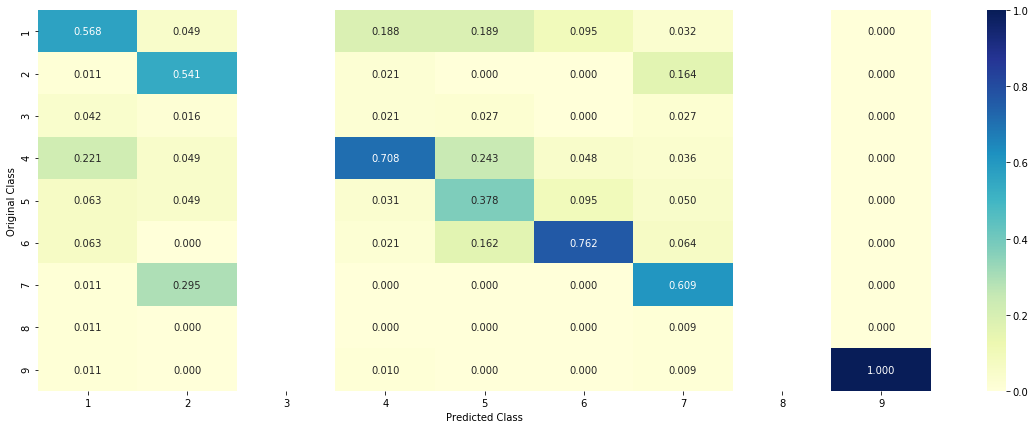

-------------------- Recall matrix (Row sum=1) --------------------


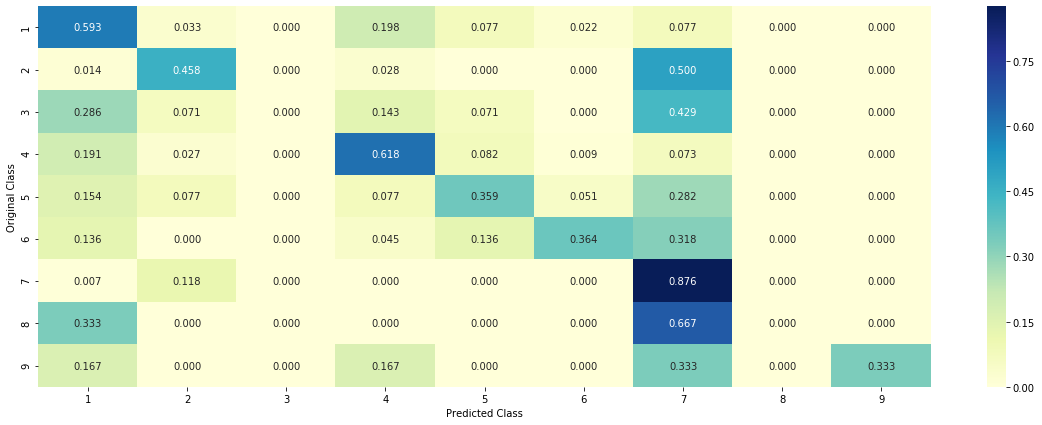

In [63]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_t4)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_t4)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_t4.toarray()))

<h2>K Nearest Neighbour Classification</h2>

<h3>Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.1244941333916727
for alpha = 11
Log Loss : 1.1471275165627643
for alpha = 15
Log Loss : 1.1717783038727412
for alpha = 21
Log Loss : 1.2043878028599164
for alpha = 31
Log Loss : 1.2343856799073543
for alpha = 41
Log Loss : 1.2723002205470517
for alpha = 51
Log Loss : 1.29698696941668
for alpha = 99
Log Loss : 1.3469082549428697


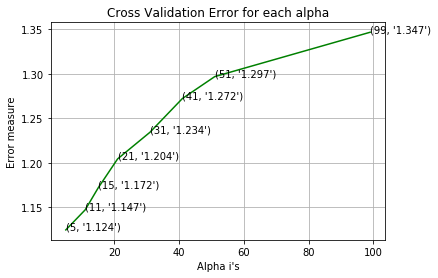

For values of best alpha =  5 The train log loss is: 0.8676826477608021
For values of best alpha =  5 The cross validation log loss is: 1.1244941333916727
For values of best alpha =  5 The test log loss is: 1.105756246985


In [66]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    clf.fit(train_x_t4, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_t4, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_t4)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)

predict_y = sig_clf.predict_proba(train_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>Testing the model with best hyper paramters</h3>

Log loss : 1.1244941333916727
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


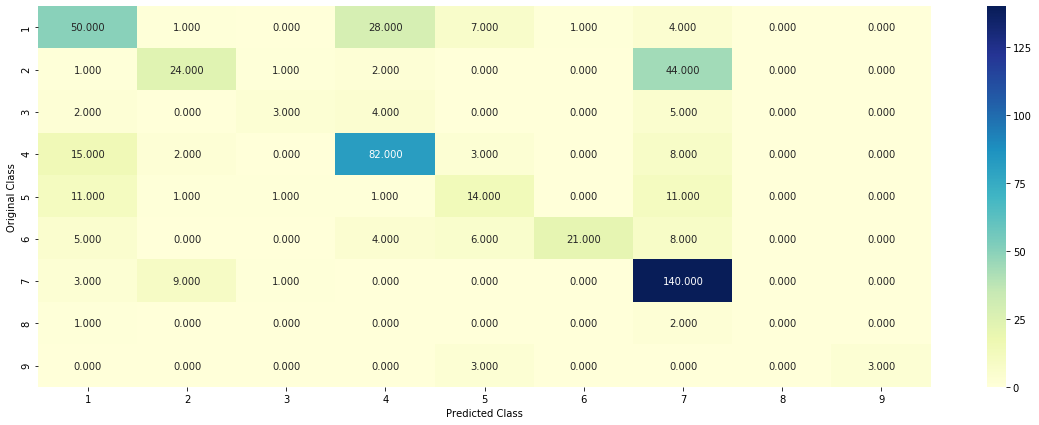

-------------------- Precision matrix (Columm Sum=1) --------------------


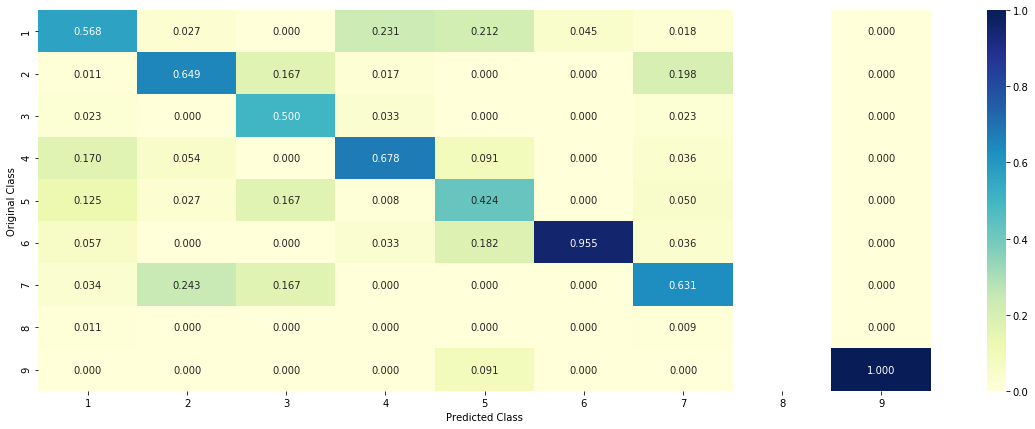

-------------------- Recall matrix (Row sum=1) --------------------


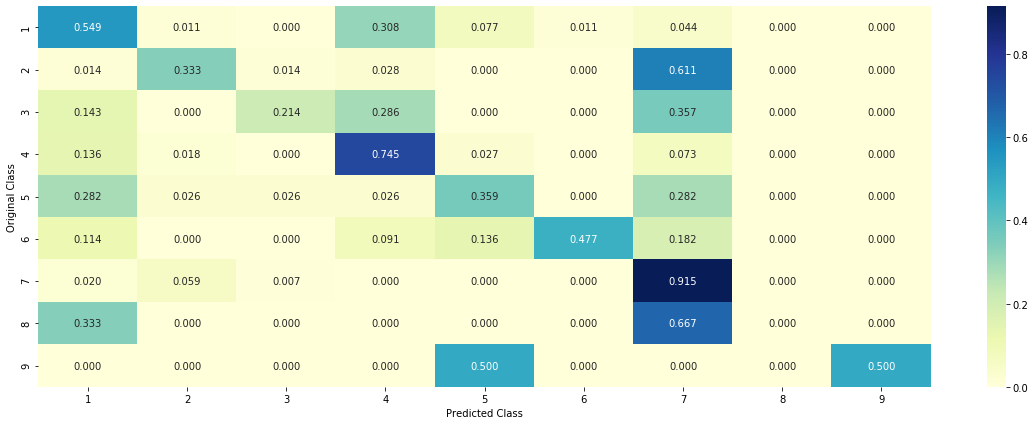

In [67]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_t4, train_y, cv_x_t4, cv_y, clf)

<h3>Sample Query point -1</h3>

In [68]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_t4[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_t4[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 1
The  5  nearest neighbours of the test points belongs to classes [1 1 1 1 1]
Fequency of nearest points : Counter({1: 5})


<h3>Sample Query Point-2 </h3>

In [69]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=-1)
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_t4[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_t4[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [1 1 1 1 1]
Fequency of nearest points : Counter({1: 5})


<h2>Logistic Regression</h2>

<h3>With Class balancing</h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.195641845860871
for alpha = 1e-05
Log Loss : 1.1644887642413504
for alpha = 0.0001
Log Loss : 1.125710025394425
for alpha = 0.001
Log Loss : 1.136605788282771
for alpha = 0.01
Log Loss : 1.2567489718024847
for alpha = 0.1
Log Loss : 1.7612300223586685
for alpha = 1
Log Loss : 1.8782962137771901
for alpha = 10
Log Loss : 1.8893755843064042
for alpha = 100
Log Loss : 1.890596943164598


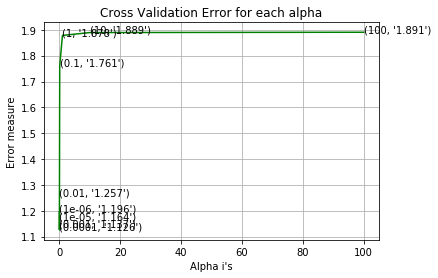

For values of best alpha =  0.0001 The train log loss is: 0.4230690998570839
For values of best alpha =  0.0001 The cross validation log loss is: 1.125710025394425
For values of best alpha =  0.0001 The test log loss is: 0.9696066103802887


In [70]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_x_t4, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_t4, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_t4)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)

predict_y = sig_clf.predict_proba(train_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing the model with best hyper paramters</h4>

Log loss : 1.125710025394425
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


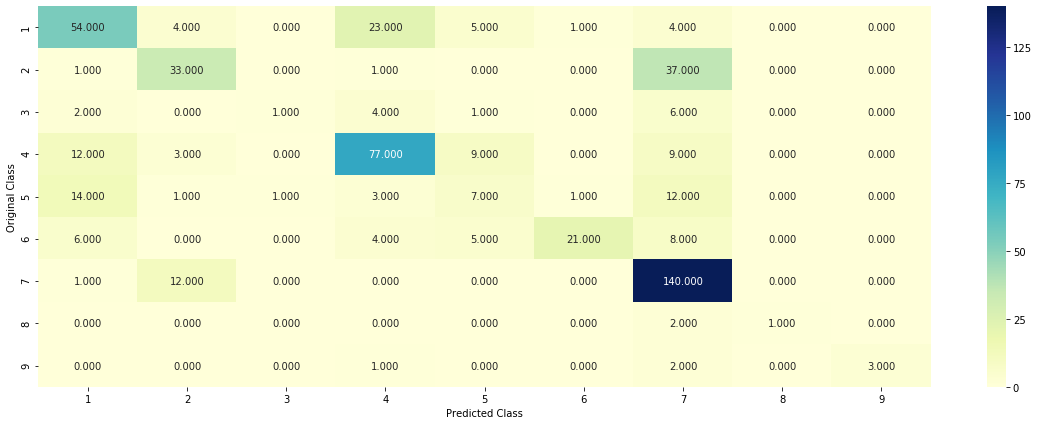

-------------------- Precision matrix (Columm Sum=1) --------------------


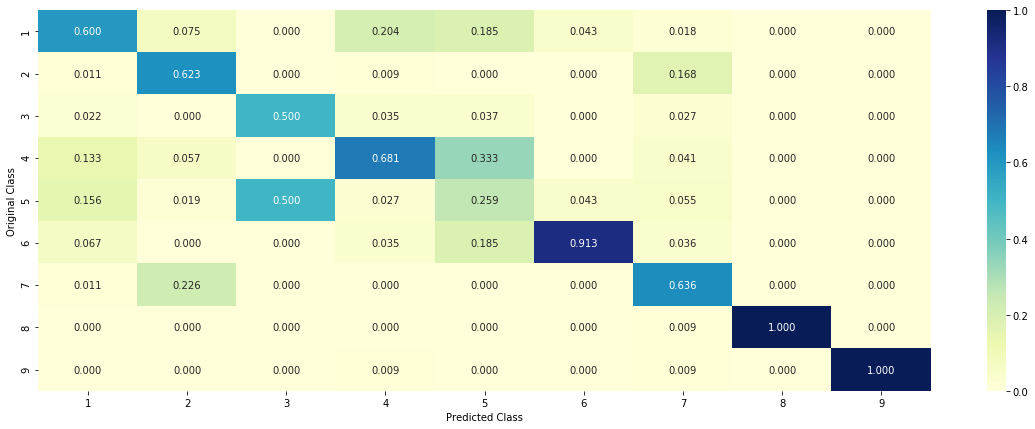

-------------------- Recall matrix (Row sum=1) --------------------


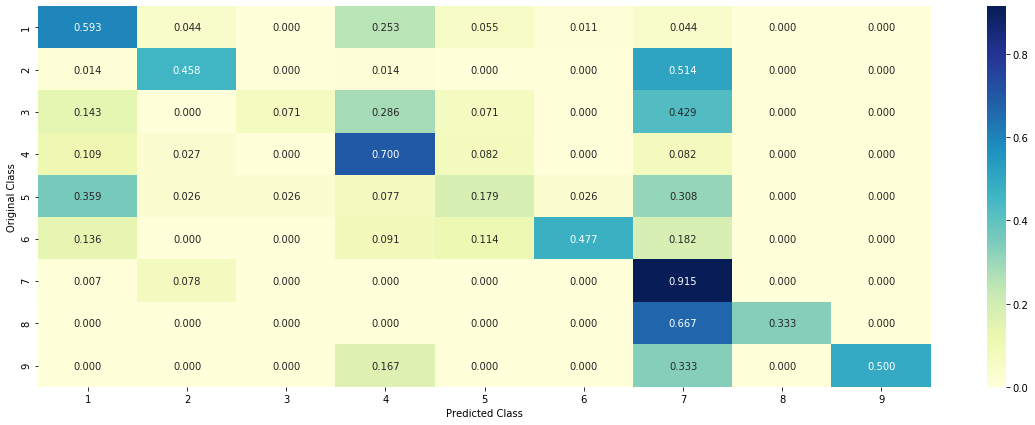

In [71]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_t4, train_y, cv_x_t4, cv_y, clf)

In [72]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h3>Without Class balancing</h3>

<h4>Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.2396891818267755
for alpha = 1e-05
Log Loss : 1.199824890389868
for alpha = 0.0001
Log Loss : 1.1636701229045228
for alpha = 0.001
Log Loss : 1.2416071753124276
for alpha = 0.01
Log Loss : 1.5432939855090457
for alpha = 0.1
Log Loss : 1.7750529802967088
for alpha = 1
Log Loss : 1.8521478278304666


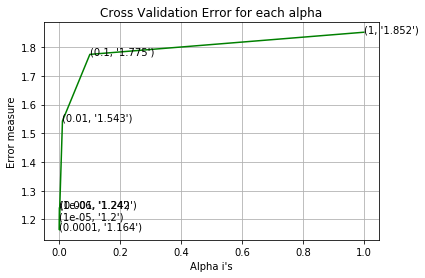

For values of best alpha =  0.0001 The train log loss is: 0.4262802509366508
For values of best alpha =  0.0001 The cross validation log loss is: 1.1636701229045228
For values of best alpha =  0.0001 The test log loss is: 1.0132894781582444


In [75]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(train_x_t4, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_t4, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_t4)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)

predict_y = sig_clf.predict_proba(train_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>Testing model with best hyper parameters</h4>

Log loss : 1.1636701229045228
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


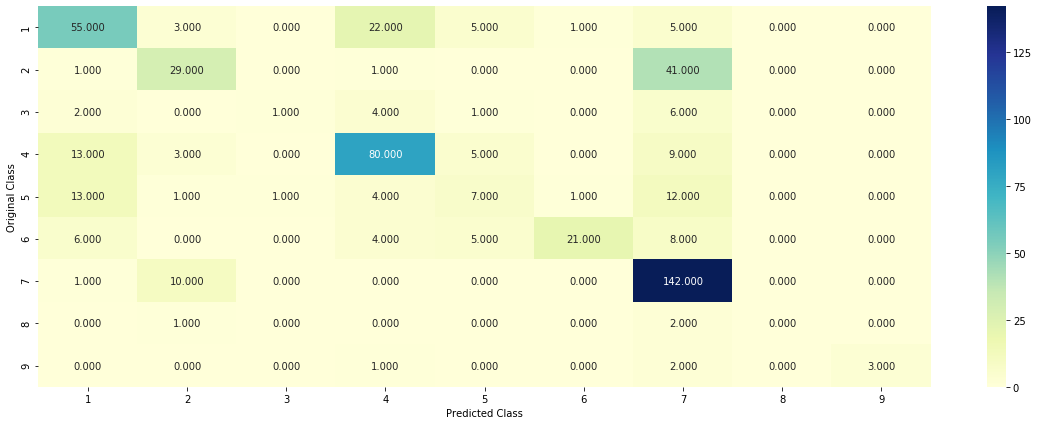

-------------------- Precision matrix (Columm Sum=1) --------------------


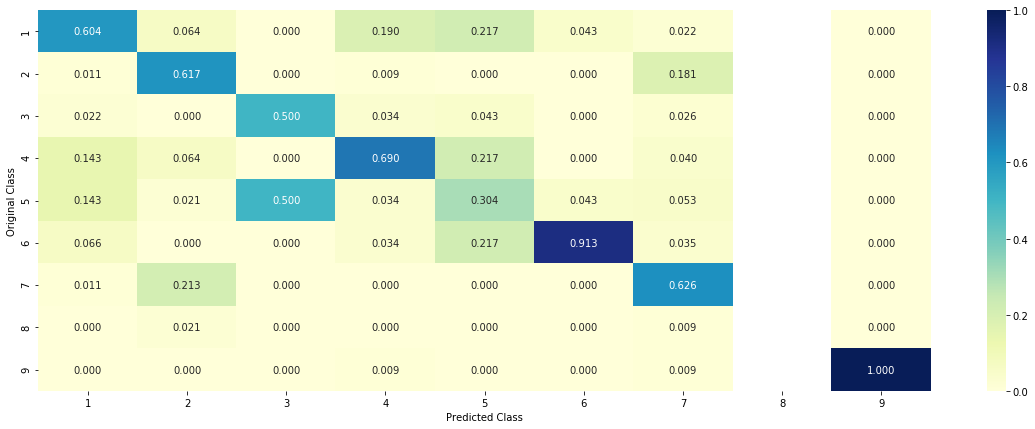

-------------------- Recall matrix (Row sum=1) --------------------


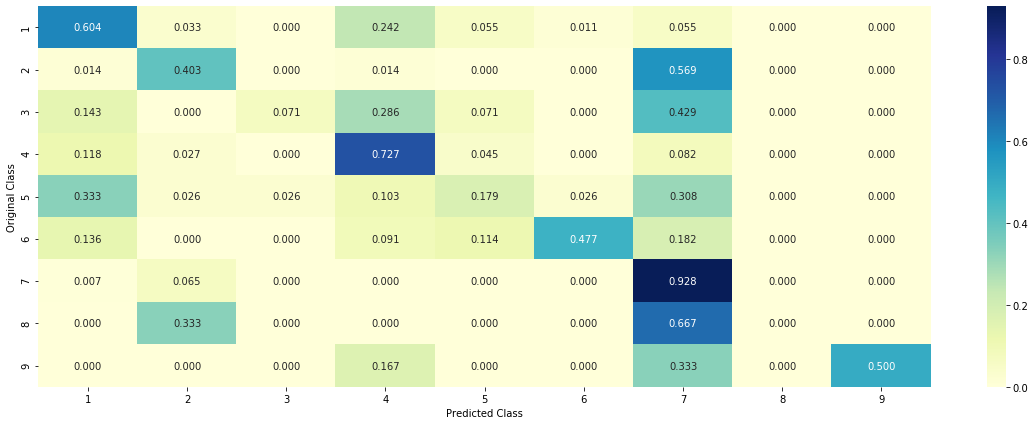

In [76]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_t4, train_y, cv_x_t4, cv_y, clf)

<h2>Linear Support Vector Machines</h2>

<h3>Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.1628380958122508
for C = 0.0001
Log Loss : 1.1104266147314692
for C = 0.001
Log Loss : 1.1123011131833194
for C = 0.01
Log Loss : 1.302289812708608
for C = 0.1
Log Loss : 1.7822291976395934
for C = 1
Log Loss : 1.8908843418873518
for C = 10
Log Loss : 1.8908847236142552
for C = 100
Log Loss : 1.8908847372826798


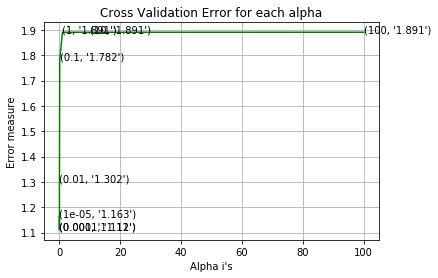

For values of best alpha =  0.0001 The train log loss is: 0.3934456834808227
For values of best alpha =  0.0001 The cross validation log loss is: 1.1104266147314692
For values of best alpha =  0.0001 The test log loss is: 1.008202299074548


In [79]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42, n_jobs=-1)
    clf.fit(train_x_t4, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_t4, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_t4)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, n_jobs=-1)
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)

predict_y = sig_clf.predict_proba(train_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_t4)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>Testing model with best hyper parameters</h3>

Log loss : 1.1104266147314692
Number of mis-classified points : 0.34962406015037595
-------------------- Confusion matrix --------------------


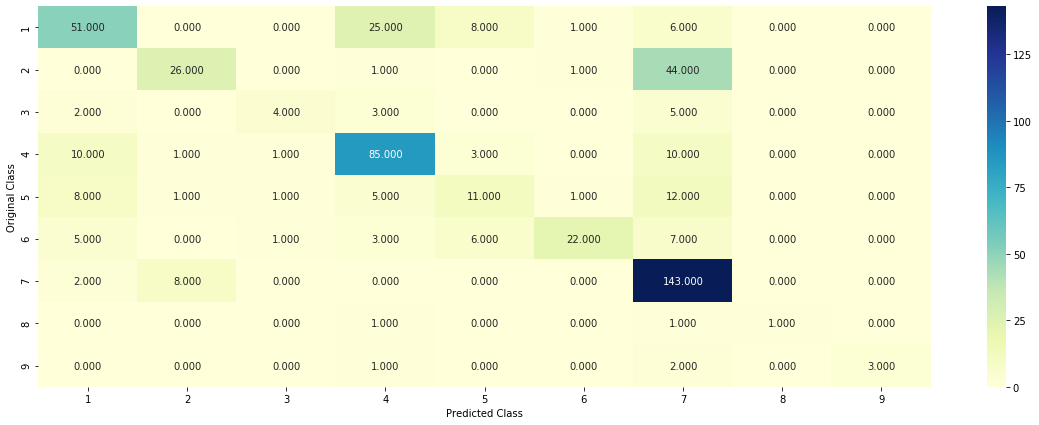

-------------------- Precision matrix (Columm Sum=1) --------------------


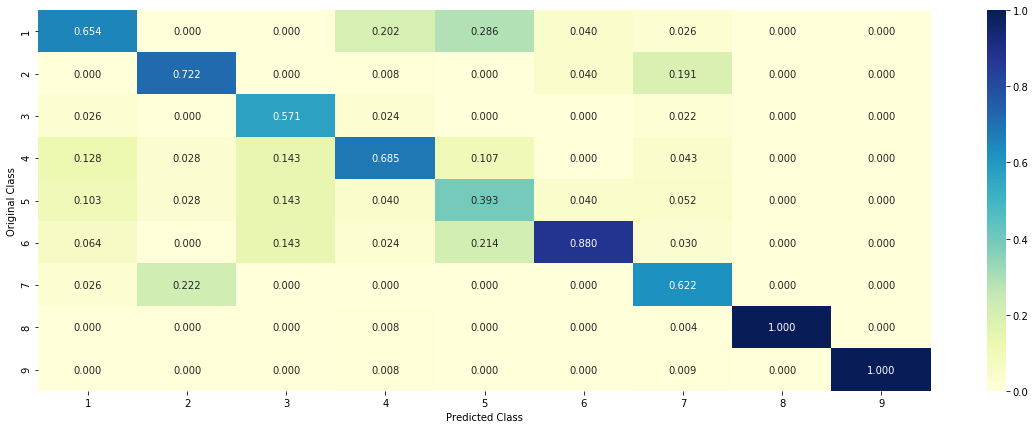

-------------------- Recall matrix (Row sum=1) --------------------


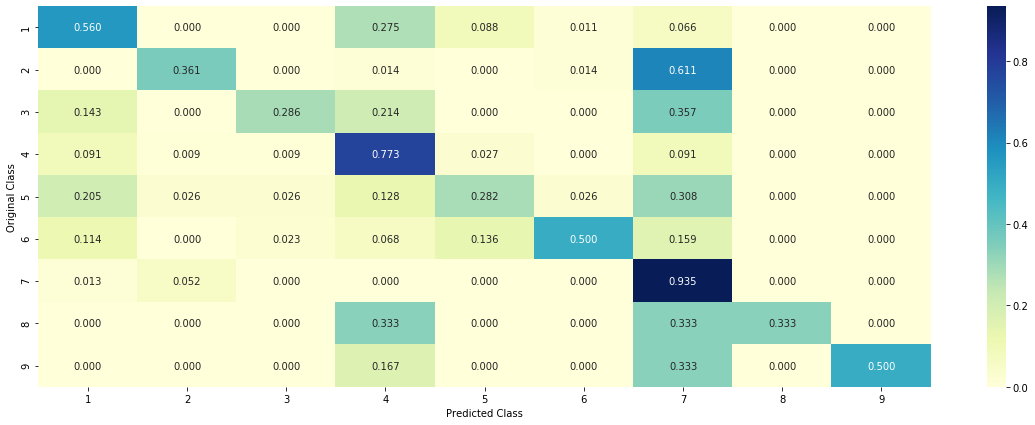

In [80]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced', n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_t4, train_y,cv_x_t4,cv_y, clf)

<h2>Random Forest Classifier</h2>

<h3>Hyper parameter tuning</h3>

In [83]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_t4, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_t4, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_t4)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_t4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_t4, train_y)

predict_y = sig_clf.predict_proba(train_x_t4)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_t4)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_t4)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.261489353513999
for n_estimators = 100 and max depth =  10
Log Loss : 1.2459825659058028
for n_estimators = 200 and max depth =  5
Log Loss : 1.245329912125218
for n_estimators = 200 and max depth =  10
Log Loss : 1.2374759323915279
for n_estimators = 500 and max depth =  5
Log Loss : 1.2367458334730974
for n_estimators = 500 and max depth =  10
Log Loss : 1.2381920894827423
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2383906046560933
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2393072945352226
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2385481375929186
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2405761201217784
For values of best estimator =  500 The train log loss is: 0.8557023953526733
For values of best estimator =  500 The cross validation log loss is: 1.2367458334730974
For values of best estimator =  500 The test log loss is: 1.1681951921580098


<h3>Testing model with best hyper parameters</h3>

Log loss : 1.2367458334730974
Number of mis-classified points : 0.45300751879699247
-------------------- Confusion matrix --------------------


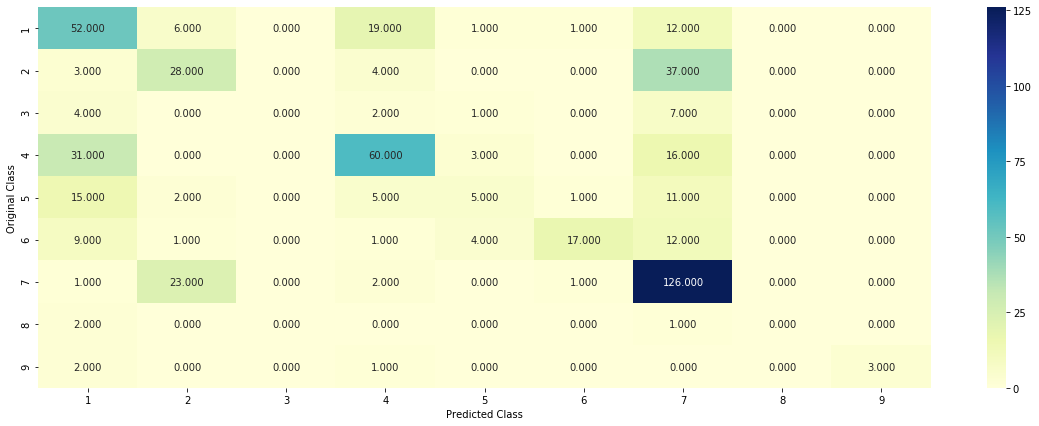

-------------------- Precision matrix (Columm Sum=1) --------------------


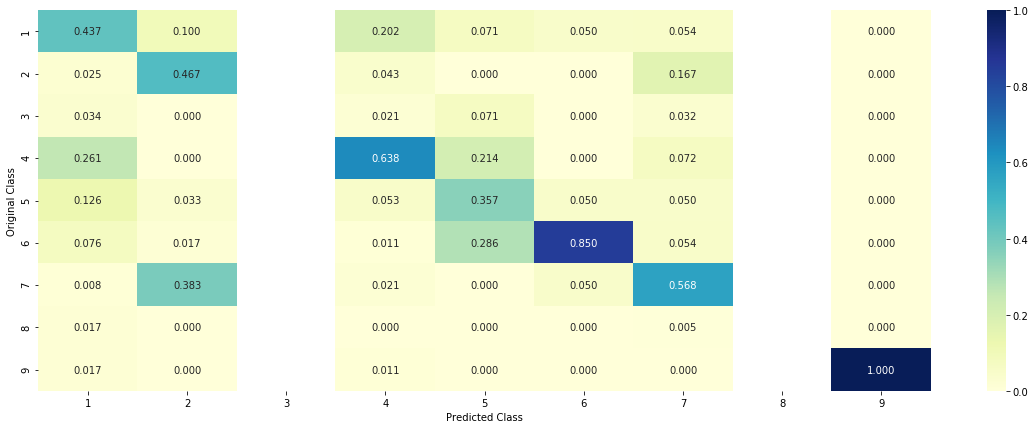

-------------------- Recall matrix (Row sum=1) --------------------


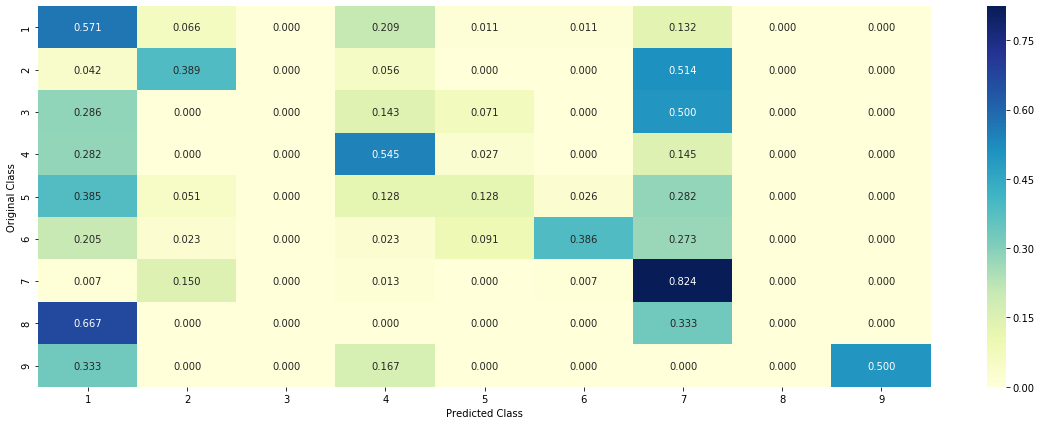

In [84]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_t4, train_y,cv_x_t4,cv_y, clf)

<h2>Stack the models </h2>

<h3>Testing with hyper parameter tuning</h3>

In [87]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0, n_jobs=-1)
clf1.fit(train_x_t4, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0, n_jobs=-1)
clf2.fit(train_x_t4, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_t4, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_t4, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_t4))))
sig_clf2.fit(train_x_t4, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_t4))))
sig_clf3.fit(train_x_t4, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_t4))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_t4, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_t4))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_t4))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.14
Support vector machines : Log Loss: 1.89
Naive Bayes : Log Loss: 1.27
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.177
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.030
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.506
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.206
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.441
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.909


<h3>Testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.5943625252046277
Log loss (CV) on the stacking classifier : 1.2057824869025242
Log loss (test) on the stacking classifier : 1.1422076308779052
Number of missclassified point : 0.3879699248120301
-------------------- Confusion matrix --------------------


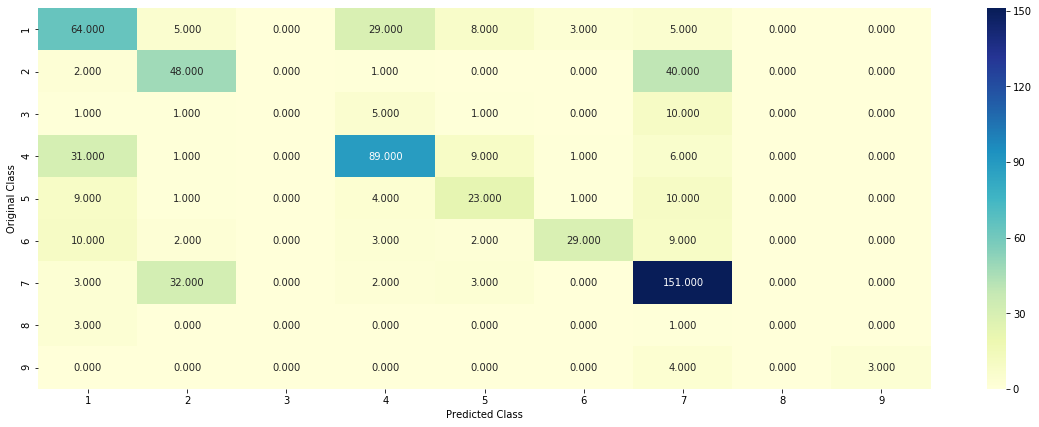

-------------------- Precision matrix (Columm Sum=1) --------------------


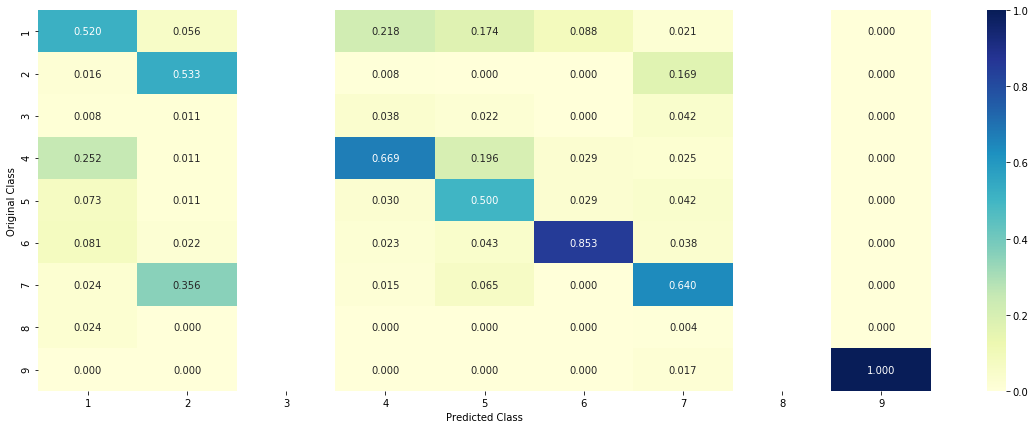

-------------------- Recall matrix (Row sum=1) --------------------


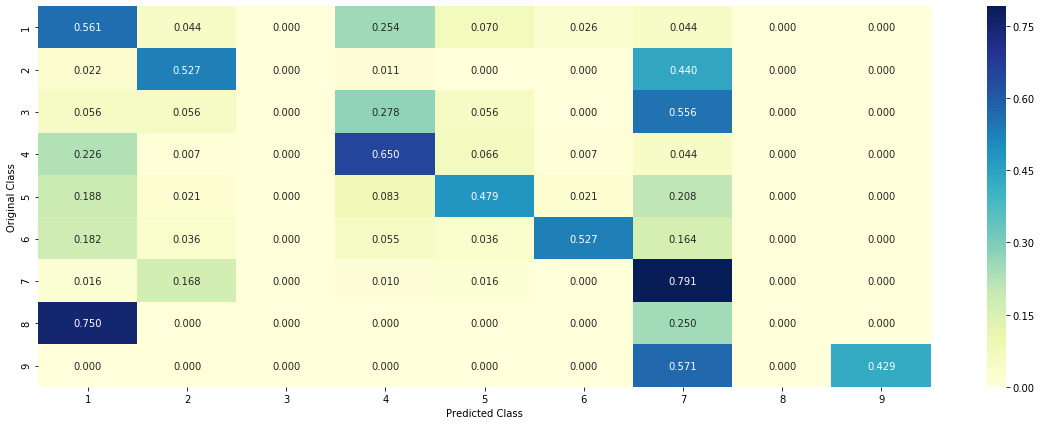

In [88]:
lr = LogisticRegression(C=0.1, n_jobs=-1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_t4, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_t4))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_t4))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_t4))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_t4)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_t4))

<h3>Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.852803163042514
Log loss (CV) on the VotingClassifier : 1.2465777716560662
Log loss (test) on the VotingClassifier : 1.1595158742044582
Number of missclassified point : 0.3819548872180451
-------------------- Confusion matrix --------------------


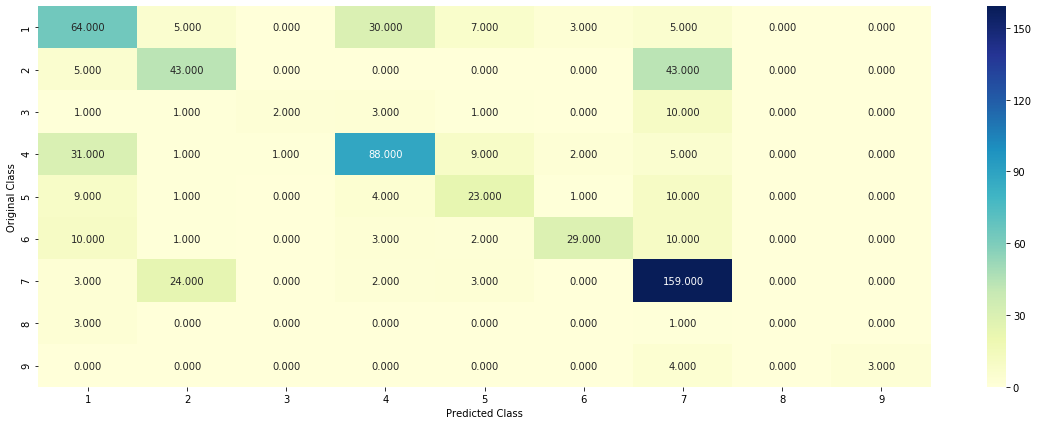

-------------------- Precision matrix (Columm Sum=1) --------------------


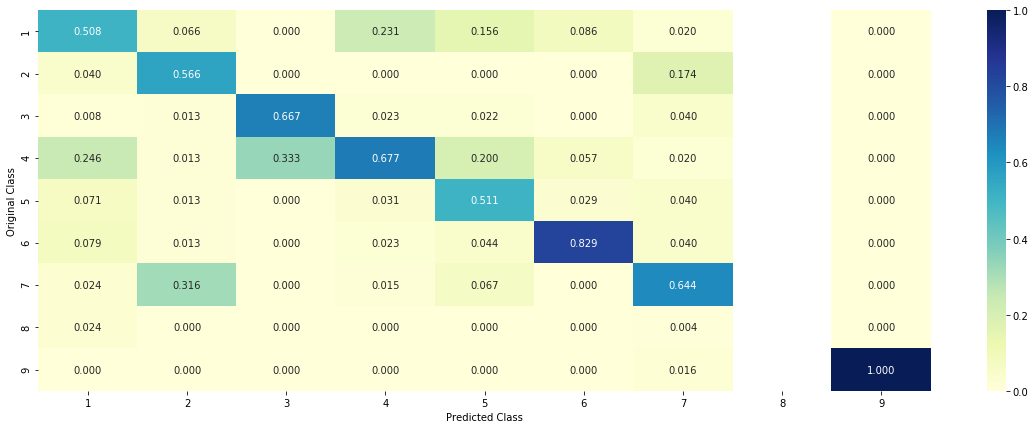

-------------------- Recall matrix (Row sum=1) --------------------


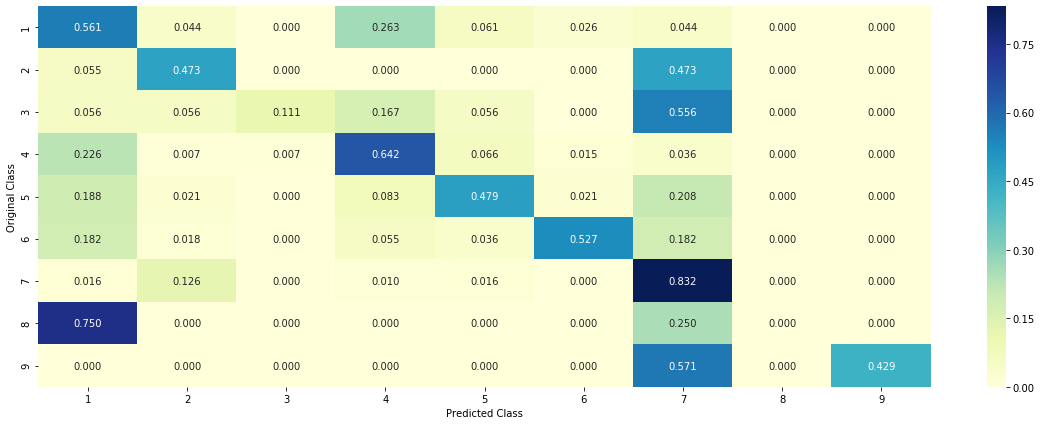

In [89]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft', n_jobs=-1)
vclf.fit(train_x_t4, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_t4)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_t4)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_t4)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_t4)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_t4))

# Conclusion

In [3]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.No.", "Model", "Best hyp", "Train", "CV", "Test", "Misclassif", "Correct", "Incorrect"]
x.add_row(["", "TASK 1 - TFIDF VECTORIZATION", "", "", "", "", "", "", ""])
x.add_row(["1", "Naïve Bayes", "1000", "0.925", "1.183", "1.186", "0.4", "72", "86"])
x.add_row(["2", "K-Nearest Neighbour", "5", "0.998", "1.257", "1.284", "0.422", "NA", "NA"])
x.add_row(["3", "Logistic Regression + Balancing", "0.001", "0.538", "1.06", "0.974", "0.372", "5.4", "1.2"])
x.add_row(["4", "Logistic Regression + w/o Balancing", "0.001", "0.532", "1.085", "0.987", "0.36", "7", "1.2"])
x.add_row(["5", "Linear SVM + Balancing", "0.001", "0.591", "1.094", "1.043", "0.366", "3.6", "1.2"])
x.add_row(["6", "Random Forest Classifier", "500", "0.668", "1.13", "1.13", "0.362", "53", "45"])
x.add_row(["7", "Stacking Classifier", "NA", "0.629", "1.123", "1.05", "0.332", "NA", "NA"])
x.add_row(["8", "Maximum Voting Classifier", "NA", "0.851", "1.132", "1.1", "NA", "NA", "NA"])
print(x)

+-------+-------------------------------------+----------+-------+-------+-------+------------+---------+-----------+
| S.No. |                Model                | Best hyp | Train |   CV  |  Test | Misclassif | Correct | Incorrect |
+-------+-------------------------------------+----------+-------+-------+-------+------------+---------+-----------+
|       |     TASK 1 - TFIDF VECTORIZATION    |          |       |       |       |            |         |           |
|   1   |             Naïve Bayes             |   1000   | 0.925 | 1.183 | 1.186 |    0.4     |    72   |     86    |
|   2   |         K-Nearest Neighbour         |    5     | 0.998 | 1.257 | 1.284 |   0.422    |    NA   |     NA    |
|   3   |   Logistic Regression + Balancing   |  0.001   | 0.538 |  1.06 | 0.974 |   0.372    |   5.4   |    1.2    |
|   4   | Logistic Regression + w/o Balancing |  0.001   | 0.532 | 1.085 | 0.987 |    0.36    |    7    |    1.2    |
|   5   |        Linear SVM + Balancing       |  0.001  

In [4]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.No.", "Model", "Best hyp", "Train", "CV", "Test", "Misclassif", "Correct", "Incorrect"]
x.add_row(["", "TASK 2 TFIDF Top 1000 features", "", "", "", "", "", "", ""])
x.add_row(["1", "Naïve Bayes", "1e-05", "0.515", "1.235", "1.237", "0.406", "2", "1"])
x.add_row(["2", "K-Nearest Neighbour", "5", "0.867", "1.138", "1.1", "0.387", "NA", "NA"])
x.add_row(["3", "Logistic Regression + Balancing", "0.001", "0.721", "1.047", "1.065", "0.385", "0.2", "0.2"])
x.add_row(["4", "Logistic Regression + w/o Balancing", "0.0001", "0.432", "1.081", "0.037", "0.372", "0.2", "0.4"])
x.add_row(["5", "Linear SVM + Balancing", "0.0001", "0.393", "1.102", "1.046", "0.366", "0", "0.6"])
x.add_row(["6", "Random Forest Classifier", "1000", "0.861", "1.238", "1.189", "0.451", "1", "2"])
x.add_row(["7", "Stacking Classifier", "NA", "0.537", "1.208", "1.231", "0.396", "NA", "NA"])
x.add_row(["8", "Maximum Voting Classifier", "NA", "0.822", "1.22", "0.384", "NA", "NA", "NA"])
print(x)

+-------+-------------------------------------+----------+-------+-------+-------+------------+---------+-----------+
| S.No. |                Model                | Best hyp | Train |   CV  |  Test | Misclassif | Correct | Incorrect |
+-------+-------------------------------------+----------+-------+-------+-------+------------+---------+-----------+
|       |    TASK 2 TFIDF Top 1000 features   |          |       |       |       |            |         |           |
|   1   |             Naïve Bayes             |  1e-05   | 0.515 | 1.235 | 1.237 |   0.406    |    2    |     1     |
|   2   |         K-Nearest Neighbour         |    5     | 0.867 | 1.138 |  1.1  |   0.387    |    NA   |     NA    |
|   3   |   Logistic Regression + Balancing   |  0.001   | 0.721 | 1.047 | 1.065 |   0.385    |   0.2   |    0.2    |
|   4   | Logistic Regression + w/o Balancing |  0.0001  | 0.432 | 1.081 | 0.037 |   0.372    |   0.2   |    0.4    |
|   5   |        Linear SVM + Balancing       |  0.0001 

In [5]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.No.", "Model", "Best hyp", "Train", "CV", "Test", "Misclassif", "Correct", "Incorrect"]
x.add_row(["", "TASK 3-LR BOW uni & bigrams", "", "", "", "", "", "", ""])
x.add_row(["1", "LR with Class Balancing", "0.01", "0.734", "1.159", "1.153", "0.4", "1", "0"])
x.add_row(["2", "LR w/o Class Balancing", "0.01", "0.725", "1.156", "1.151", "0.39", "0.8", "0"])
print(x)

+-------+-----------------------------+----------+-------+-------+-------+------------+---------+-----------+
| S.No. |            Model            | Best hyp | Train |   CV  |  Test | Misclassif | Correct | Incorrect |
+-------+-----------------------------+----------+-------+-------+-------+------------+---------+-----------+
|       | TASK 3-LR BOW uni & bigrams |          |       |       |       |            |         |           |
|   1   |   LR with Class Balancing   |   0.01   | 0.734 | 1.159 | 1.153 |    0.4     |    1    |     0     |
|   2   |    LR w/o Class Balancing   |   0.01   | 0.725 | 1.156 | 1.151 |    0.39    |   0.8   |     0     |
+-------+-----------------------------+----------+-------+-------+-------+------------+---------+-----------+


In [6]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.No.", "Model", "Best hyp", "Train", "CV", "Test", "Misclassif", "Correct", "Incorrect"]
x.add_row(["", "TASK 4-Reducing CV & Test Logloss", "", "", "", "", "", "", ""])
x.add_row(["1", "Naïve Bayes", "o.1", "0.729", "1.268", "1.218", "1.268", "0", "0"])
x.add_row(["2", "K-Nearest Neighbour", "5", "0.867", "1.124", "1.105", "1.124", "NA", "NA"])
x.add_row(["3", "LR + Balancing", "0.0001", "0.423", "1.125", "0.969", "1.125", "0", "0"])
x.add_row(["4", "LR + w/o Balancing", "0.0001", "0.426", "1.163", "1.013", "1.163", "0", "0"])
x.add_row(["5", "Linear SVM + Balancing", "0.0001", "0.393", "1.11", "1.008", "1.11", "0", "0"])
x.add_row(["6", "Random Forest Classifier", "500", "0.855", "1.236", "1.168", "1.236", "0", "0"])
x.add_row(["7", "Stacking Classifier", "NA", "0.594", "1.205", "1.142", "0.387", "NA", "NA"])
x.add_row(["8", "Maximum Voting Classifier", "NA", "0.852", "1.246", "1.159", "NA", "NA", "NA"])
print(x)

+-------+-----------------------------------+----------+-------+-------+-------+------------+---------+-----------+
| S.No. |               Model               | Best hyp | Train |   CV  |  Test | Misclassif | Correct | Incorrect |
+-------+-----------------------------------+----------+-------+-------+-------+------------+---------+-----------+
|       | TASK 4-Reducing CV & Test Logloss |          |       |       |       |            |         |           |
|   1   |            Naïve Bayes            |   o.1    | 0.729 | 1.268 | 1.218 |   1.268    |    0    |     0     |
|   2   |        K-Nearest Neighbour        |    5     | 0.867 | 1.124 | 1.105 |   1.124    |    NA   |     NA    |
|   3   |           LR + Balancing          |  0.0001  | 0.423 | 1.125 | 0.969 |   1.125    |    0    |     0     |
|   4   |         LR + w/o Balancing        |  0.0001  | 0.426 | 1.163 | 1.013 |   1.163    |    0    |     0     |
|   5   |       Linear SVM + Balancing      |  0.0001  | 0.393 |  1.11 |

# Summary

In Task 4, Logistic Regression with class balancing gives the lowest Test log loss out of other models. 

Logistic Regression with class balancing Test Log loss is 0.969